# Goal of this project:
 Optimize email campaign performance to improve engagement and increase account linking and funding rates.

In [1]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns;

%matplotlib inline

pd.options.display.max_columns = None


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My\ Drive/Colab\ Notebooks/Govalley_Project3_email

/content/drive/My Drive/Colab Notebooks/Govalley_Project3_email


# Load experiment Design data

## 1. Load Email list

In [4]:
# hard code Email lists. Email ID is the index of the Email in the list

PO_number_list = ['ml_funding_enables_investing','ml_investing_starts_here','ml_explore_the_app_investing',
                  'ml_funding_faq','ml_user_clustering_emails_fracs','ml_funding_is_safe','ml_picking_an_investment',
                  'ml_investing_101','ml_diversified_portfolio','ml_explore_the_app_list']

## 2. Load user segment information

In [5]:
#user_uuid is the count of unique users in each segment
segment_group_init_df = pd.read_csv('sample_segment_groups.csv')
segment_group_init_df = segment_group_init_df.drop(columns='Unnamed: 0')
segment_group_init_df

group_id  approved_within6M_flag  link_flag  recent_activity_flag(20days)  \
0          0                   False      False                         False   
1          1                   False      False                          True   
2          2                   False      False                          True   
3          3                   False       True                         False   
4          4                   False       True                          True   
5          5                   False       True                          True   
6          6                    True      False                         False   
7          7                    True      False                          True   
8          8                    True      False                          True   
9          9                    True       True                         False   
10        10                    True       True                          True   
11        11                    True       True                          True   

    5day_trade_flag  user_uuid                  group_name  
0             False    4418550       ML_unfund_exp_control  
1             False     314921                     20D_Act  
2              True     409786              20D_Act-5D_Act  
3             False     941341                        link  
4             False     102541                link-20D_Act  
5              True     136513         link-20D_Act-5D_Act  
6             False     814827                      6M_App  
7             False     218938              6M_App-20D_Act  
8              True     233445       6M_App-20D_Act-5D_Act  
9             False     127008                 6M_App-link  
10            False      47883         6M_App-link-20D_Act  
11             True      69697  6M_App-link-20D_Act-5D_Act

In [6]:
segment_group_init_df.user_uuid.sum() #this is whole population in company

7835450

In [7]:
segment_group_init_df.columns

Index(['group_id', 'approved_within6M_flag', 'link_flag',
       'recent_activity_flag(20days)', '5day_trade_flag', 'user_uuid',
       'group_name'],
      dtype='object')

## 3. Load sampled users with Email delivery orders for the experiment

In [8]:
sample_exp_df = pd.read_csv('sample_uuid_email_order.csv')
sample_exp_df.head()

user_uuid  group_id               group_name  order_0  \
0   id_2623238174270264636         0  ML_unfund_exp_control_D        5   
1  id_14752263936159847779         0  ML_unfund_exp_control_D        3   
2   id_3723259155072282145         0  ML_unfund_exp_control_D        8   
3   id_9433964625840258739         0  ML_unfund_exp_control_D        1   
4  id_17251718038176858460         0  ML_unfund_exp_control_D        6   

   order_1  order_2  order_3  order_4  order_5  order_6  order_7  order_8  \
0        7        3        4        8        9        0        1        6   
1        1        6        0        5        9        4        8        7   
2        7        3        6        1        4        2        9        0   
3        8        0        6        5        7        4        9        3   
4        1        8        0        7        3        5        2        9   

   order_9  
0        2  
1        2  
2        5  
3        2  
4        4

In [9]:
sample_exp_df.shape #this is sample in the company

(480000, 13)

# load Email Events





In [10]:
email_event_summary_df = pd.read_csv('email_events.csv')

In [11]:
email_event_summary_df.head()
email_event_summary_df.shape


(9553330, 6)

In [12]:
#we can see all the events name:
email_event_summary_df['event'].unique()

array(['open', 'unsubscribe', 'spamreport', 'deferred', 'bounce',
       'processed', 'delivered', 'dropped'], dtype=object)

 bounce email: some people not successfully received email due to server problem eventhough emails delivered to them

# load current user status

In [13]:
user_event_df = pd.read_csv('user_events.csv')
user_event_df.head()

user_uuid               group_name  \
0   id_2623238174270264636  ML_unfund_exp_control_D   
1  id_14752263936159847779  ML_unfund_exp_control_D   
2   id_3723259155072282145  ML_unfund_exp_control_D   
3   id_9433964625840258739  ML_unfund_exp_control_D   
4  id_17251718038176858460  ML_unfund_exp_control_D   

  ml_funding_enables_investing ml_investing_starts_here  \
0                          NaN                      NaN   
1                    delivered                delivered   
2                    delivered                delivered   
3                    delivered                delivered   
4                          NaN                      NaN   

  ml_explore_the_app_investing ml_funding_faq ml_user_clustering_emails_fracs  \
0                          NaN            NaN                             NaN   
1                    delivered      delivered                       delivered   
2                         open           open                            open   
3                    delivered      delivered                       delivered   
4                          NaN            NaN                             NaN   

  ml_funding_is_safe ml_picking_an_investment ml_investing_101  \
0                NaN                      NaN              NaN   
1          delivered                delivered        delivered   
2          delivered                delivered        delivered   
3          delivered                delivered        delivered   
4                NaN                      NaN              NaN   

  ml_diversified_portfolio ml_explore_the_app_list              approved_at  \
0                      NaN                     NaN  2020-01-14 16:31:59.295   
1                     open               delivered  2019-01-29 16:22:26.866   
2                delivered                    open  2019-02-01 00:01:48.853   
3                delivered               delivered  2020-03-17 21:02:43.906   
4                      NaN                     NaN  2019-12-30 18:23:15.726   

           first_funded_at first_linked_bank_account_at  \
0                      NaN                          NaN   
1                      NaN                          NaN   
2  2020-12-04 20:41:55.146      2020-12-04 20:41:37.842   
3                      NaN                          NaN   
4                      NaN                          NaN   

   5d_trading_avg_event_count  2d_non_trading_avg_event_count  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                        53.0                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

   20d_trading_avg_event_count  8d_non_trading_avg_event_count  \
0                          NaN                             NaN   
1                          NaN                             NaN   
2                        171.0                             NaN   
3                          NaN                             NaN   
4                          NaN                             NaN   

   1d_trading_avg_event_count  1d_non_trading_avg_event_count  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

   num_received_email  
0                   0  
1                   9  
2                   6  
3                  10  
4                   0

In [14]:
user_event_df.shape

(480000, 22)

From here, we know this table is event information for each user

In [15]:
user_event_df.group_name.unique()

array(['ML_unfund_exp_control_D', 'ML_unfund_exp_control_W', '20D_Act_D',
       '20D_Act_W', '20D_Act-5D_Act_D', '20D_Act-5D_Act_W', 'link_D',
       'link_W', 'link-20D_Act_D', 'link-20D_Act_W',
       'link-20D_Act-5D_Act_D', 'link-20D_Act-5D_Act_W', '6M_App_D',
       '6M_App_W', '6M_App-20D_Act_D', '6M_App-20D_Act_W',
       '6M_App-20D_Act-5D_Act_D', '6M_App-20D_Act-5D_Act_W',
       '6M_App-link_D', '6M_App-link_W', '6M_App-link-20D_Act_D',
       '6M_App-link-20D_Act_W', '6M_App-link-20D_Act-5D_Act_D',
       '6M_App-link-20D_Act-5D_Act_W'], dtype=object)

In [16]:
user_event_df.columns

Index(['user_uuid', 'group_name', 'ml_funding_enables_investing',
       'ml_investing_starts_here', 'ml_explore_the_app_investing',
       'ml_funding_faq', 'ml_user_clustering_emails_fracs',
       'ml_funding_is_safe', 'ml_picking_an_investment', 'ml_investing_101',
       'ml_diversified_portfolio', 'ml_explore_the_app_list', 'approved_at',
       'first_funded_at', 'first_linked_bank_account_at',
       '5d_trading_avg_event_count', '2d_non_trading_avg_event_count',
       '20d_trading_avg_event_count', '8d_non_trading_avg_event_count',
       '1d_trading_avg_event_count', '1d_non_trading_avg_event_count',
       'num_received_email'],
      dtype='object')

# Load the current status for control groups.

They have the same sagmentation rules in the beginning of the experiment.  
These users did not received any Emails during the experiment.

In [114]:
fund_control_df = pd.read_csv('control_groups_rate.csv')
fund_control_df.head()

group_name  num_users_in_control  num_funded_in_control  \
0              20D_Act-5D_Act_D                369786                   7802   
1                     20D_Act_D                274921                   4053   
2       6M_App-20D_Act-5D_Act_D                193445                  11556   
3              6M_App-20D_Act_D                178938                   5636   
4  6M_App-link-20D_Act-5D_Act_D                 29697                   3047   

   funding_rate_in_control  num_link_in_control  link_rate_in_control  
0                 0.021099                 9899              0.026770  
1                 0.014742                 5143              0.018707  
2                 0.059738                13396              0.069250  
3                 0.031497                 6570              0.036717  
4                 0.102603                29697              1.000000

# Calculate Metrics for treatment groups




# Email open rate

1.  What is the best E-mail to send?
> not all users received messeage so we only include users who received messages.
> $ email\ open\ rate_{message\ i} = \frac{open\ users_{message\ i}}{open\ users_{message\ i}+delivered\ users_{message\ i}}$.




In [18]:
#create a dataframe to include all messages as columns and user's response
ml_user_events=user_event_df.iloc[:,2:12]
#User defined function which takes a series returns a  percentage of "open" among all users who received the message (exclude NaN):
def get_col_mean(series):
   return series.apply(lambda x: 1 if x=="open" else (np.NaN if pd.isnull(x) else 0)).mean(skipna=True)
#apply this function to each column (each message) of dataframe, and then sort percentage in descending order
open_rate_messages=ml_user_events.apply(get_col_mean, axis=0)
open_rate_messages

ml_funding_enables_investing       0.173985
ml_investing_starts_here           0.175461
ml_explore_the_app_investing       0.173756
ml_funding_faq                     0.259781
ml_user_clustering_emails_fracs    0.182563
ml_funding_is_safe                 0.177012
ml_picking_an_investment           0.178662
ml_investing_101                   0.176229
ml_diversified_portfolio           0.173160
ml_explore_the_app_list            0.177784
dtype: float64

In [19]:
#Sort percentage rate of "openning" in descending order. We can clearly see what are the top messages with highest engagement rate of users
pd.DataFrame(open_rate_messages,columns=["rate"],index=ml_user_events.columns).sort_values(by="rate",ascending=False)

rate
ml_funding_faq                   0.259781
ml_user_clustering_emails_fracs  0.182563
ml_picking_an_investment         0.178662
ml_explore_the_app_list          0.177784
ml_funding_is_safe               0.177012
ml_investing_101                 0.176229
ml_investing_starts_here         0.175461
ml_funding_enables_investing     0.173985
ml_explore_the_app_investing     0.173756
ml_diversified_portfolio         0.173160

* The message for users in all treatment groups with highest responsive open rate is **"funding faq"**. The Email open rate is 0.2598. This is the **best email to send**.
* The second highest open rate is the message "user_clustering_email_fracs".The open rate is 0.1826
* All other email contents' open rate are around 0.17.
* There are some missing values for messages which is neither "delivered" not "open".

2. What are the important user segment factors that correlate to Email open rate?

> I think we should calculate open rate for each group:

> $open\ rate_{group\ i}=\frac{open\ messages_{group\ i}}{total\ not\ NA \ messages_{group\ i}}$




In [20]:
#Firstly calculate total opens for each users across 10 messages, and add this column called "total open" to dataframe
user_event_df["total open"]=ml_user_events.apply(lambda x: x.str.count('open'),axis=0).sum(axis=1)
#Then sum total opens over each group based on group name:
total_open_df=pd.DataFrame(user_event_df.groupby(by="group_name")["total open"].sum(),columns=["group_name","total open"])

In [21]:
#this step calculate delivered messages (including open messages) for each group:
#Exclude message with NaN status which means messages not be sent.
user_event_df["not na"]=10-ml_user_events.apply(lambda x: x.isna(),axis=0).sum(axis=1)
nona_df=pd.DataFrame(user_event_df.groupby(by="group_name")["not na"].sum(),columns=["group_name","not na"])

In [22]:
#open rate is total num of open messages / total non-na messages:
open_rate=total_open_df["total open"]/nona_df['not na']

# NOTE: open_rate include groups with both weekly (_W) and daily (_D)
open_rate

group_name
20D_Act-5D_Act_D                0.176917
20D_Act-5D_Act_W                0.176766
20D_Act_D                       0.192787
20D_Act_W                       0.189364
6M_App-20D_Act-5D_Act_D         0.190035
6M_App-20D_Act-5D_Act_W         0.191078
6M_App-20D_Act_D                0.198487
6M_App-20D_Act_W                0.191193
6M_App-link-20D_Act-5D_Act_D    0.215386
6M_App-link-20D_Act-5D_Act_W    0.209863
6M_App-link-20D_Act_D           0.204623
6M_App-link-20D_Act_W           0.203052
6M_App-link_D                   0.177129
6M_App-link_W                   0.174470
6M_App_D                        0.173141
6M_App_W                        0.170971
ML_unfund_exp_control_D         0.150215
ML_unfund_exp_control_W         0.147482
link-20D_Act-5D_Act_D           0.186157
link-20D_Act-5D_Act_W           0.187335
link-20D_Act_D                  0.193844
link-20D_Act_W                  0.197474
link_D                          0.160041
link_W                          0.159591
dtype: float64

We can see under the same segment group, there is **no large difference between two time frequencies** (daily and twice a week). The order will be preserved, if we take average of daily and weekly open rate in the same segment group. So that we can compare correlation bewteen user segments and open rate rather than time frequency and open rate.
* Between two frequencies, daily is always better than twice a week.

In [23]:
#We can see daily and weekly open rate for the same group are very close, so we can average weekly and daily open rates for each group:
open_rate_df_DW=pd.DataFrame(open_rate,columns=["Average open rate"])
open_rate_df_DW["group name"]=open_rate.index.map(lambda x:x[:-2])
#Results sort by open rate in Descending order:
#NOTE: "Reset_index" is to make index to column after groupby
open_rate_df=open_rate_df_DW.groupby(by="group name")["Average open rate"].mean().sort_values(ascending=False).reset_index()
open_rate_df

group name  Average open rate
0   6M_App-link-20D_Act-5D_Act           0.212624
1          6M_App-link-20D_Act           0.203838
2                 link-20D_Act           0.195659
3               6M_App-20D_Act           0.194840
4                      20D_Act           0.191076
5        6M_App-20D_Act-5D_Act           0.190556
6          link-20D_Act-5D_Act           0.186746
7               20D_Act-5D_Act           0.176841
8                  6M_App-link           0.175800
9                       6M_App           0.172056
10                        link           0.159816
11       ML_unfund_exp_control           0.148848

Now we can see from this table which treatment groups have higher open rates and which groups don't:
* **Trend**:
1.  users with four segments engaged have highest open rate:  
 - users whose account activated within 6M, linked bank account, has activity within 20 days and traded within 5 days are most likely to open the emails among all groups.

2. Users with none of segments engaged have lowest open rate.
3. Groups with more engaged segments are generally have higher open rates.

*  **How single segment affects open rate**:
4. Users with factor "Link" alone has lowest open rates among all factors.
5. Users with factor "20day-activity" alone has highest open rates among all factors.

 2. Correlation analysis on open rate:
 Next we should join open rate table with segment user table to perform correlation analysis based on same group name :

In [24]:
#Join open rate table and segment table:
seg_open_df=open_rate_df.merge(segment_group_init_df,left_on="group name", right_on="group_name",how="inner").drop(columns=["group_id","user_uuid","group_name"])
seg_open_df

group name  Average open rate  approved_within6M_flag  \
0   6M_App-link-20D_Act-5D_Act           0.212624                    True   
1          6M_App-link-20D_Act           0.203838                    True   
2                 link-20D_Act           0.195659                   False   
3               6M_App-20D_Act           0.194840                    True   
4                      20D_Act           0.191076                   False   
5        6M_App-20D_Act-5D_Act           0.190556                    True   
6          link-20D_Act-5D_Act           0.186746                   False   
7               20D_Act-5D_Act           0.176841                   False   
8                  6M_App-link           0.175800                    True   
9                       6M_App           0.172056                    True   
10                        link           0.159816                   False   
11       ML_unfund_exp_control           0.148848                   False   

    link_flag  recent_activity_flag(20days)  5day_trade_flag  
0        True                          True             True  
1        True                          True            False  
2        True                          True            False  
3       False                          True            False  
4       False                          True            False  
5       False                          True             True  
6        True                          True             True  
7       False                          True             True  
8        True                         False            False  
9       False                         False            False  
10       True                         False            False  
11      False                         False            False

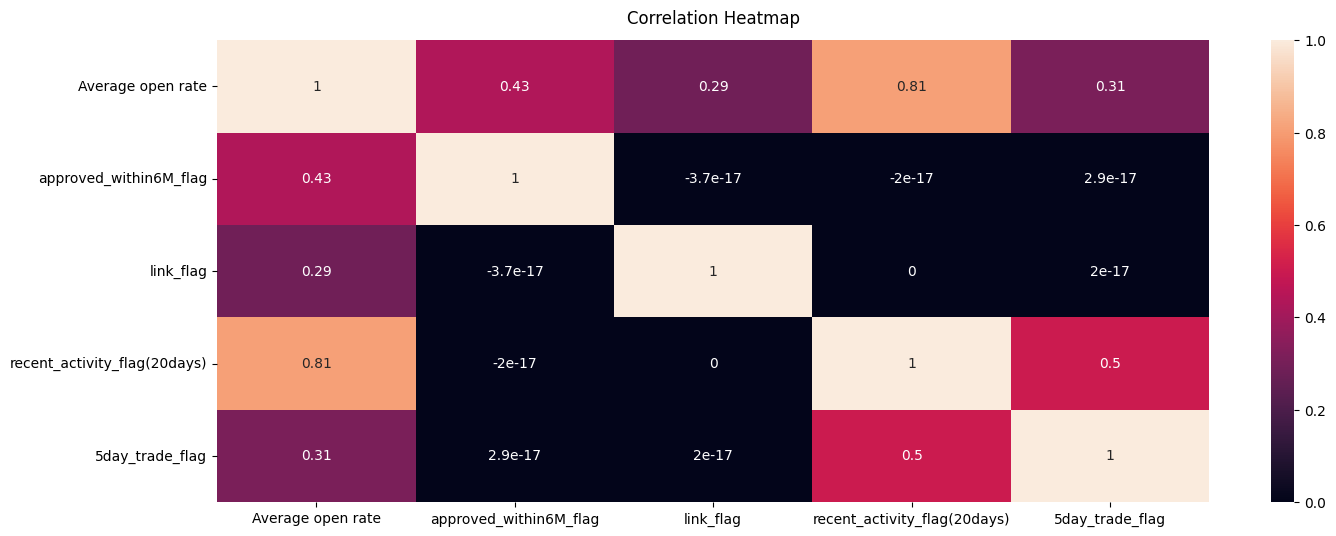

In [25]:
#Finally, we will plot a heatmap to illustrate correlation between open rate and each of segment factors:
import seaborn as sns
import matplotlib.pyplot as plt
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(seg_open_df.corr(numeric_only=True),annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Correlation analysis:
We found that open rate are all correlated with 4 segment factors. We are not sure if four factors causes open rate or open rate is the reason. In order to answer whether there is causal relationship between segment factors and open rate, we need to perform AB test.
Analysis is in order of strongness of correlation:
* Open rate & recent activity flag (20 days) have **highly positive correlation**:
users who have recent activity within 20 days are more likely to click on email.
* Open rate & approved within 6 months: users whose account activated within 6 months are moderate positive correlated with rate that users open the emails.
* Open rate & trade within 5 datys: users who traded within 5 days are moderate positive correlated with rate that users open the emails.
* Open rate & link account with bank account: users who linked their bank account have low positive correlation with open rate.



 ***More detailed open rate for each specific segment group and email sending frequencies:***



*   using heatmap to represent open rate for each group




<ipython-input-26-db4c1b32705c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_count_df[e] = delivered_count_df[e].notnull()
<ipython-input-26-db4c1b32705c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_count_df[e] = open_count_df[e] == 'open'


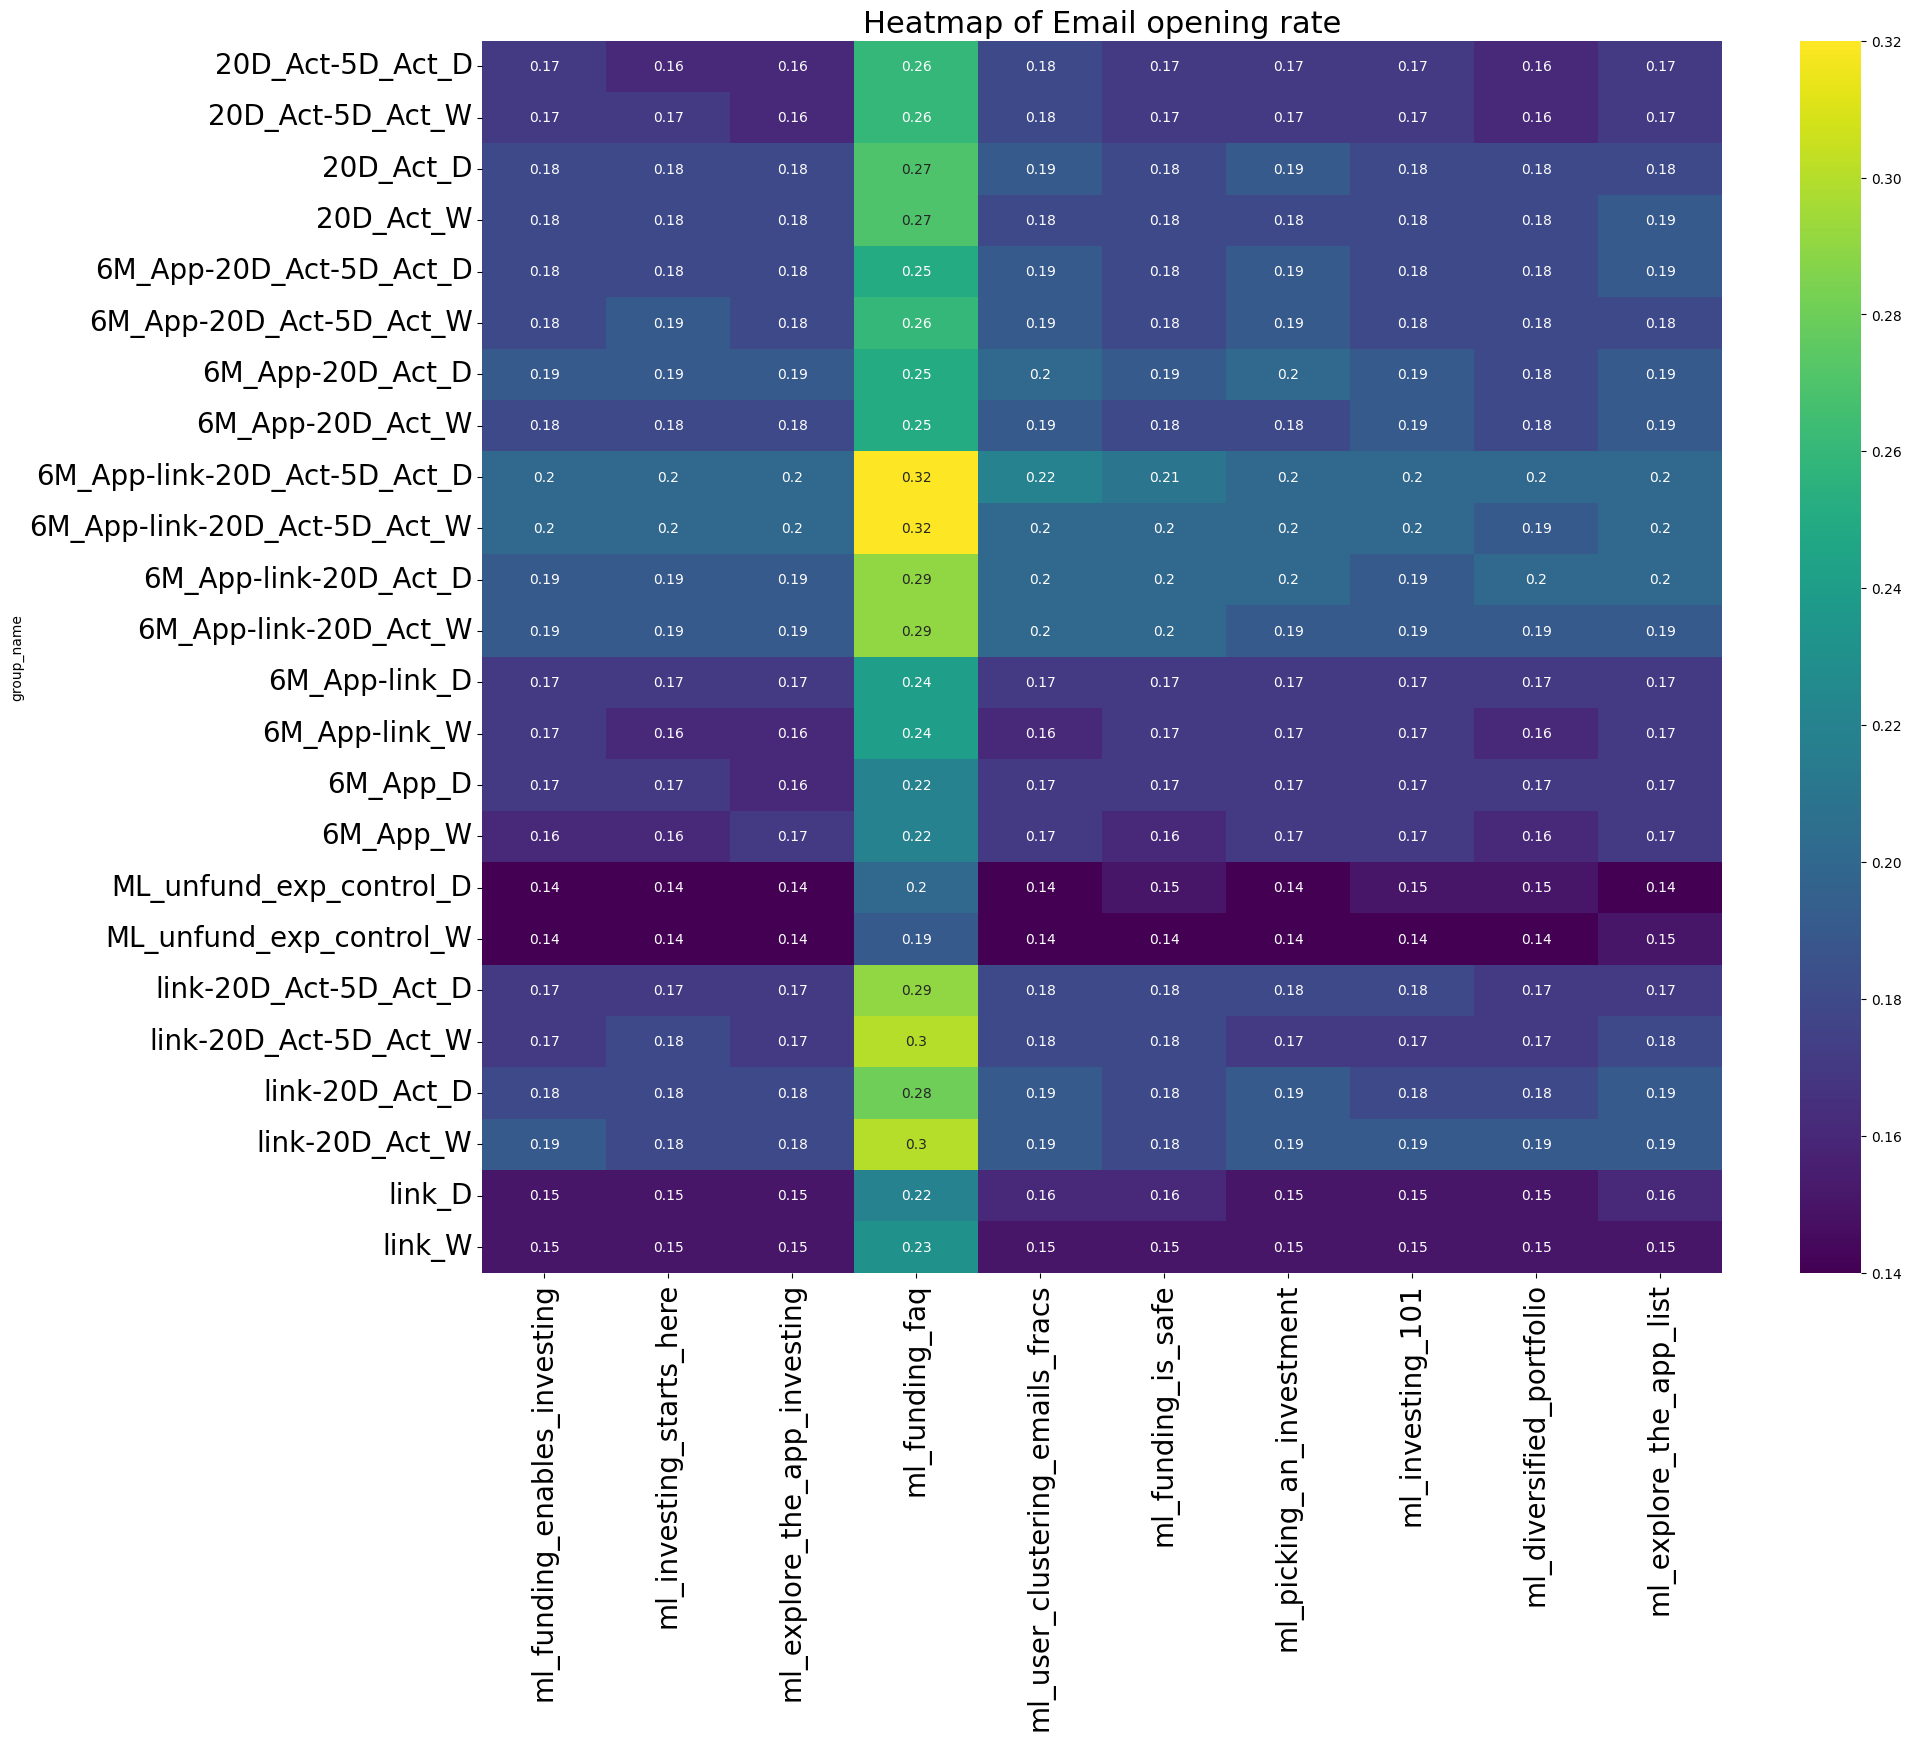

In [26]:
#not null rows are extracted:
delivered_count_df = user_event_df[['user_uuid','group_name']+PO_number_list]
for e in PO_number_list:
    delivered_count_df[e] = delivered_count_df[e].notnull()
delivered_count_df = delivered_count_df.groupby('group_name').sum().reset_index()
#open rows are extracted:
open_count_df = user_event_df[['user_uuid','group_name']+PO_number_list]
for e in PO_number_list:
    open_count_df[e] = open_count_df[e] == 'open'
open_count_df = open_count_df.groupby('group_name').sum().reset_index()
#open/not null gives open rate
open_rate_df_specific = open_count_df
for e in PO_number_list:
    open_rate_df_specific[e] = open_count_df[e]/delivered_count_df[e]
result = open_rate_df_specific.round(2).set_index('group_name').iloc[:,1:]
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Heatmap of Email opening rate',fontsize=22)


plt.show()

Again from detailed heatmap, we can see most of segment groups daily is always have higher open rate than weekly.

**More specific correlation for all factors: messages, frenquency, segment:**


In [112]:
open_rate_flat_df = open_rate_df_specific.copy()
open_rate_flat_df['daily'] = open_rate_flat_df['group_name'].str.contains('_D')
open_rate_flat_df['twice_a_week'] = open_rate_flat_df['group_name'].str.contains('_W')
open_rate_flat_df['group_name'] = open_rate_flat_df['group_name'].str.strip('_D')#remove character "_D" and return other chars
open_rate_flat_df['group_name'] = open_rate_flat_df['group_name'].str.strip('_W')
#Now group name doesnt contain frequency
open_rate_flat_df = open_rate_flat_df.merge(segment_group_init_df,how = 'left',on='group_name')#
open_rate_flat_df.head()

group_name                                        user_uuid_x  \
0         20D_Act-5D_Act  id_108730096545553319id_17033316498541460763id...   
1         20D_Act-5D_Act  id_2056875396497046488id_1805272204200540957id...   
2                20D_Act  id_18066165271746208616id_6958192350271394294i...   
3                20D_Act  id_13471668544681414958id_1648044025520909996i...   
4  6M_App-20D_Act-5D_Act  id_16995527587209681272id_10930775585852851635...   

   ml_funding_enables_investing  ml_investing_starts_here  \
0                      0.165939                  0.163058   
1                      0.165001                  0.166262   
2                      0.181723                  0.181460   
3                      0.175677                  0.180598   
4                      0.179627                  0.181125   

   ml_explore_the_app_investing  ml_funding_faq  \
0                      0.164710        0.262532   
1                      0.163899        0.262368   
2                      0.183006        0.268066   
3                      0.178330        0.268779   
4                      0.177652        0.253823   

   ml_user_clustering_emails_fracs  ml_funding_is_safe  \
0                         0.176959            0.167004   
1                         0.180184            0.165736   
2                         0.191501            0.183780   
3                         0.184494            0.182677   
4                         0.191775            0.180762   

   ml_picking_an_investment  ml_investing_101  ml_diversified_portfolio  \
0                  0.171553          0.168336                  0.158152   
1                  0.168832          0.165896                  0.163083   
2                  0.186031          0.182467                  0.184967   
3                  0.180267          0.182079                  0.175449   
4                  0.189102          0.182554                  0.177647   

   ml_explore_the_app_list  daily  twice_a_week  group_id  \
0                 0.170918   True         False         2   
1                 0.166474  False          True         2   
2                 0.184855   True         False         1   
3                 0.185445  False          True         1   
4                 0.186271   True         False         8   

   approved_within6M_flag  link_flag  recent_activity_flag(20days)  \
0                   False      False                          True   
1                   False      False                          True   
2                   False      False                          True   
3                   False      False                          True   
4                    True      False                          True   

   5day_trade_flag  user_uuid_y  
0             True       409786  
1             True       409786  
2            False       314921  
3            False       314921  
4             True       233445

In [113]:
open_rate_flat_template_df = open_rate_flat_df.copy()#shallow copy
open_rate_flat_template_df[PO_number_list] = False
open_rate_flat_template_df.shape
#Next, concatenate dataframes recursively to obtain a long format. Each time one message set to T, rest messages are F, open rate are filled accordingly.
open_rate_flat_TF_df = pd.DataFrame()
for e in PO_number_list:
    temp = open_rate_flat_template_df.copy()
    temp[e] = True
    temp['open_rate'] = open_rate_flat_df[e]
    open_rate_flat_TF_df = pd.concat([open_rate_flat_TF_df, temp])

open_rate_flat_TF_df = open_rate_flat_TF_df.reset_index()
open_rate_flat_TF_df = open_rate_flat_TF_df.drop(columns = ['index'])
open_rate_flat_TF_df.head()

group_name                                        user_uuid_x  \
0         20D_Act-5D_Act  id_108730096545553319id_17033316498541460763id...   
1         20D_Act-5D_Act  id_2056875396497046488id_1805272204200540957id...   
2                20D_Act  id_18066165271746208616id_6958192350271394294i...   
3                20D_Act  id_13471668544681414958id_1648044025520909996i...   
4  6M_App-20D_Act-5D_Act  id_16995527587209681272id_10930775585852851635...   

   ml_funding_enables_investing  ml_investing_starts_here  \
0                          True                     False   
1                          True                     False   
2                          True                     False   
3                          True                     False   
4                          True                     False   

   ml_explore_the_app_investing  ml_funding_faq  \
0                         False           False   
1                         False           False   
2                         False           False   
3                         False           False   
4                         False           False   

   ml_user_clustering_emails_fracs  ml_funding_is_safe  \
0                            False               False   
1                            False               False   
2                            False               False   
3                            False               False   
4                            False               False   

   ml_picking_an_investment  ml_investing_101  ml_diversified_portfolio  \
0                     False             False                     False   
1                     False             False                     False   
2                     False             False                     False   
3                     False             False                     False   
4                     False             False                     False   

   ml_explore_the_app_list  daily  twice_a_week  group_id  \
0                    False   True         False         2   
1                    False  False          True         2   
2                    False   True         False         1   
3                    False  False          True         1   
4                    False   True         False         8   

   approved_within6M_flag  link_flag  recent_activity_flag(20days)  \
0                   False      False                          True   
1                   False      False                          True   
2                   False      False                          True   
3                   False      False                          True   
4                    True      False                          True   

   5day_trade_flag  user_uuid_y  open_rate  
0             True       409786   0.165939  
1             True       409786   0.165001  
2            False       314921   0.181723  
3            False       314921   0.175677  
4             True       233445   0.179627

In [29]:
#Now, we can call correlation for each column to see
corr = open_rate_flat_TF_df.iloc[:,2:].corr()#remove first two columns
corr = corr.sort_values(by=['open_rate'], ascending =False)
corr['open_rate']

open_rate                          1.000000
ml_funding_faq                     0.793531
recent_activity_flag(20days)       0.450146
group_id                           0.364588
approved_within6M_flag             0.241516
5day_trade_flag                    0.172443
link_flag                          0.160358
daily                              0.026641
ml_user_clustering_emails_fracs   -0.025562
twice_a_week                      -0.026641
ml_picking_an_investment          -0.065907
ml_explore_the_app_list           -0.074458
ml_funding_is_safe                -0.082867
ml_investing_101                  -0.090776
ml_investing_starts_here          -0.098976
ml_funding_enables_investing      -0.114963
ml_explore_the_app_investing      -0.117040
ml_diversified_portfolio          -0.122984
user_uuid_y                       -0.413757
Name: open_rate, dtype: float64

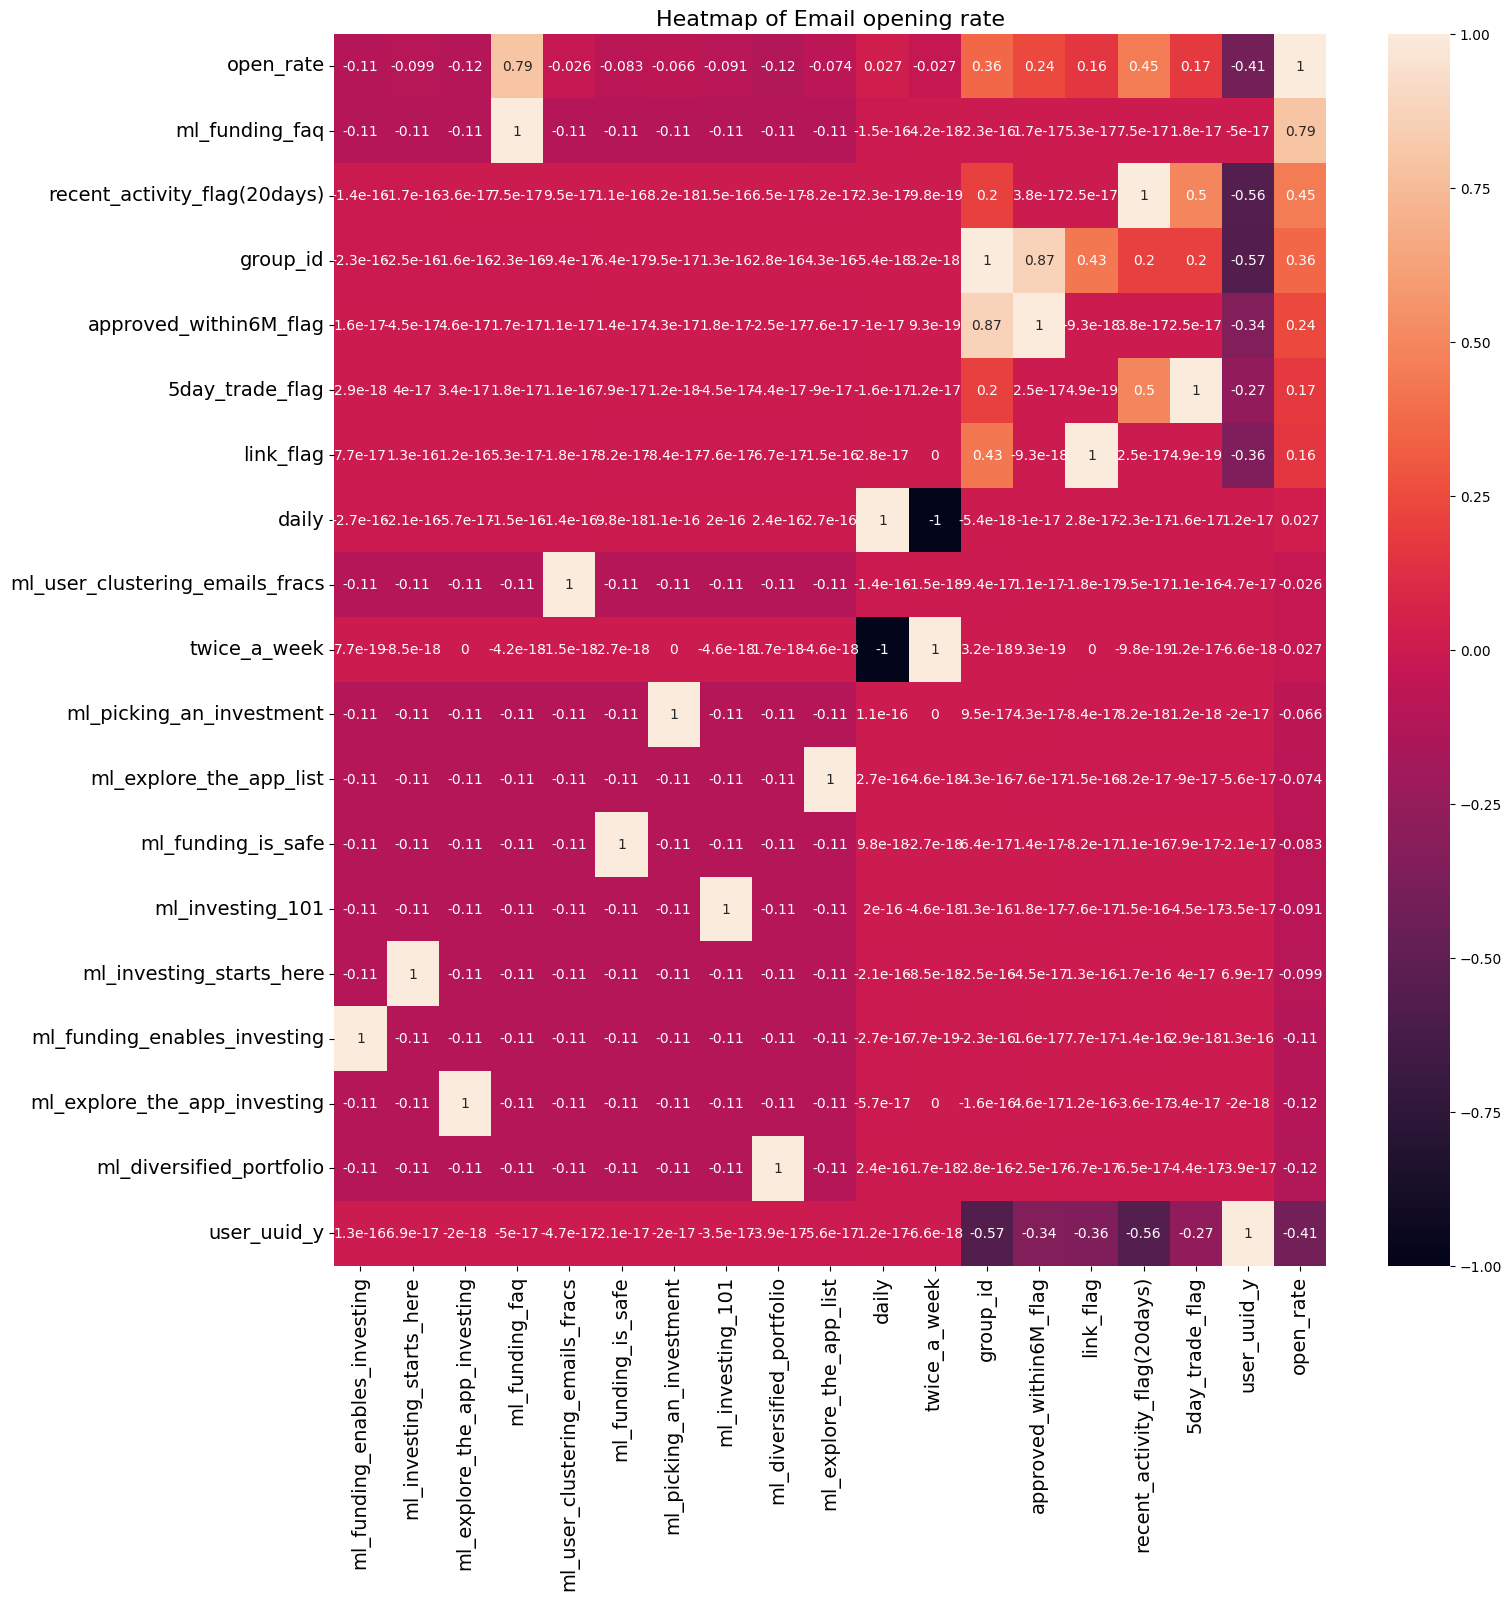

In [119]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, annot=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Heatmap of Email opening rate',fontsize=16)
plt.show()

What we see from the heatmap w.r.t open rate:

Positive impact:
*   As group ID increases, open rate increases, meaning high participation brings higher open rate.
*   Message "ML_funding frac" boosts open rate substancially
*   Having recent actively in last 20 days, users will more likely to open the link
*   People who have accounts approved within 6 months are more likely to open the link.
*   People have smaller user ID, more likely to open the link

Negative impact:
*   Frequency has no impact on open rate, twice a week even have slight negative impact.
*   Other messages have slight negative impact on open rate











# **Check negative effects, such as 'report spam', 'unsubscribe'. Events such as closing account can be tracked in user activity table.**

**Negative events counts for each message, and segment group.**
*    We can see which message has highest disikes rate by users,
*   Also which group produce users who don't like these message in general



In [30]:
neg_count_df = user_event_df[['group_name']+PO_number_list]
for e in PO_number_list:
    neg_count_df[e] = ((neg_count_df[e] == 'spamreport') | (neg_count_df[e] == 'unsubscribe'))

neg_count_df = neg_count_df.groupby('group_name').sum().reset_index()#we don't need user_uuid

# Add the sums as a new row to the DataFrame
column_sums = neg_count_df.sum()
neg_count_df.loc['Column Total'] = column_sums
# Add the row sum
neg_count_df['Row_Total'] = neg_count_df.iloc[:,1:].sum(axis=1)
neg_count_df.head(30)

<ipython-input-30-76518fb86765>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_count_df[e] = ((neg_count_df[e] == 'spamreport') | (neg_count_df[e] == 'unsubscribe'))


group_name  \
0                                              20D_Act-5D_Act_D   
1                                              20D_Act-5D_Act_W   
2                                                     20D_Act_D   
3                                                     20D_Act_W   
4                                       6M_App-20D_Act-5D_Act_D   
5                                       6M_App-20D_Act-5D_Act_W   
6                                              6M_App-20D_Act_D   
7                                              6M_App-20D_Act_W   
8                                  6M_App-link-20D_Act-5D_Act_D   
9                                  6M_App-link-20D_Act-5D_Act_W   
10                                        6M_App-link-20D_Act_D   
11                                        6M_App-link-20D_Act_W   
12                                                6M_App-link_D   
13                                                6M_App-link_W   
14                                                     6M_App_D   
15                                                     6M_App_W   
16                                      ML_unfund_exp_control_D   
17                                      ML_unfund_exp_control_W   
18                                        link-20D_Act-5D_Act_D   
19                                        link-20D_Act-5D_Act_W   
20                                               link-20D_Act_D   
21                                               link-20D_Act_W   
22                                                       link_D   
23                                                       link_W   
Column Total  20D_Act-5D_Act_D20D_Act-5D_Act_W20D_Act_D20D_A...   

              ml_funding_enables_investing  ml_investing_starts_here  \
0                                        2                         7   
1                                        2                         3   
2                                        4                         4   
3                                        7                         3   
4                                        5                         4   
5                                        4                         5   
6                                        4                         4   
7                                        4                         4   
8                                       10                         6   
9                                        3                         3   
10                                       9                         6   
11                                       9                         5   
12                                       6                         3   
13                                       3                         2   
14                                       7                         9   
15                                       3                         6   
16                                       4                         5   
17                                       4                         3   
18                                       7                         9   
19                                       5                         4   
20                                      13                         8   
21                                       7                         5   
22                                       6                        10   
23                                       7                         8   
Column Total                           135                       126   

              ml_explore_the_app_investing  ml_funding_faq  \
0                                        5               7   
1                                        1               7   
2                                        1               5   
3                                        3               3   
4                                        3               4   
5                                        5               4   
6  

Group "6M_App-link-20D_Act-5D_Act_D" has very high spam or unsubscribe rate for all emails

# Link and Funding rate

some people take other actions other than "open", "delivered", such as "unsubscribe", "spamreport". These people have trouble receiving emails, so here we do not need to include them. So we only include people whose number of received emails>0 because we only care about response from sending email . See example below:

In [31]:
user_event_df['ml_investing_101'].unique()

array([nan, 'delivered', 'open', 'unsubscribe', 'spamreport'],
      dtype=object)

What are link and funding rates for the treatment groups?


 *Fund rate*:
- We will calculate fund rate for each of treatment group:
* We first select users from treatmen groups (exclude users who didn't receive emails), and then group fund by group name, then calculate total. Next, exclude users who didnt fund, then group by group name, calculate fund total, and then fund rate.


* $fund\ rate_{message\ i} = \frac{fund\ users_{message\ i}}{total\ received\ emailed \ users_{message\ i}}$.

In [32]:
fund_exp_df = user_event_df[user_event_df['num_received_email']>0].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df = fund_exp_df.rename(columns = {'user_uuid':'num_users_received_email'})
fund_exp_df.head()

group_name  num_users_received_email
0         20D_Act-5D_Act_D                     18918
1         20D_Act-5D_Act_W                     18966
2                20D_Act_D                     18606
3                20D_Act_W                     18711
4  6M_App-20D_Act-5D_Act_D                     18927

In [33]:
user_event_df.columns

Index(['user_uuid', 'group_name', 'ml_funding_enables_investing',
       'ml_investing_starts_here', 'ml_explore_the_app_investing',
       'ml_funding_faq', 'ml_user_clustering_emails_fracs',
       'ml_funding_is_safe', 'ml_picking_an_investment', 'ml_investing_101',
       'ml_diversified_portfolio', 'ml_explore_the_app_list', 'approved_at',
       'first_funded_at', 'first_linked_bank_account_at',
       '5d_trading_avg_event_count', '2d_non_trading_avg_event_count',
       '20d_trading_avg_event_count', '8d_non_trading_avg_event_count',
       '1d_trading_avg_event_count', '1d_non_trading_avg_event_count',
       'num_received_email', 'total open', 'not na'],
      dtype='object')

In [34]:
# funding rate
temp = user_event_df[user_event_df['first_funded_at'].notnull()].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_funded'] = temp['user_uuid']
fund_exp_df['funding_rate'] = fund_exp_df['num_funded'] /fund_exp_df['num_users_received_email']

# similar idea to calculate link rate (only care about people who can receive emails)
# link rate
temp = user_event_df[user_event_df['first_linked_bank_account_at'].notnull()].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_link'] = temp['user_uuid']
fund_exp_df['link_rate'] = fund_exp_df['num_link'] /fund_exp_df['num_users_received_email']
fund_exp_df.loc[fund_exp_df['link_rate']>1,'link_rate'] = 1

# activity rate, 6 activity features having at least one number >0
act_list = []
for a in user_event_df.columns:
    if '_event_count' in a:
        act_list.append(a)

temp = user_event_df[(user_event_df[act_list].sum(axis=1)>0) & (user_event_df['num_received_email']>0)].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_act'] = temp['user_uuid']
fund_exp_df['act_rate'] = fund_exp_df['num_act'] /fund_exp_df['num_users_received_email']
#fund_exp_df.loc[fund_exp_df['act_rate']>1,'act_rate'] = 1


**Here is the table of funding rate, link rate and activity rate for each segment group:**
* sorted by funding rate

In [35]:
fund_exp_df.sort_values(by="funding_rate",ascending=False)

group_name  num_users_received_email  num_funded  \
8   6M_App-link-20D_Act-5D_Act_D                     18799        2143   
9   6M_App-link-20D_Act-5D_Act_W                     18888        2114   
4        6M_App-20D_Act-5D_Act_D                     18927        1259   
5        6M_App-20D_Act-5D_Act_W                     19066        1252   
10         6M_App-link-20D_Act_D                     18725         822   
18         link-20D_Act-5D_Act_D                     18818         780   
11         6M_App-link-20D_Act_W                     18742         757   
19         link-20D_Act-5D_Act_W                     18778         749   
6               6M_App-20D_Act_D                     18646         690   
7               6M_App-20D_Act_W                     18752         644   
21                link-20D_Act_W                     18538         485   
20                link-20D_Act_D                     18551         461   
0               20D_Act-5D_Act_D                     18918         451   
1               20D_Act-5D_Act_W                     18966         450   
2                      20D_Act_D                     18606         357   
3                      20D_Act_W                     18711         310   
12                 6M_App-link_D                     18126         255   
14                      6M_App_D                     17864         240   
15                      6M_App_W                     17910         238   
13                 6M_App-link_W                     18280         240   
22                        link_D                     17697         148   
23                        link_W                     17730         140   
16       ML_unfund_exp_control_D                     16530         113   
17       ML_unfund_exp_control_W                     16531          89   

    funding_rate  num_link  link_rate  num_act  act_rate  
8       0.113995     20000   1.000000    18799  1.000000  
9       0.111923     20000   1.000000    18888  1.000000  
4       0.066519      1465   0.077403    18927  1.000000  
5       0.065667      1454   0.076261    19066  1.000000  
10      0.043899     20000   1.000000    10116  0.540240  
18      0.041450     20000   1.000000    18818  1.000000  
11      0.040391     20000   1.000000    10172  0.542738  
19      0.039887     20000   1.000000    18778  1.000000  
6       0.037005       792   0.042476     9129  0.489596  
7       0.034343       759   0.040476     9243  0.492907  
21      0.026162     20000   1.000000    10273  0.554159  
20      0.024850     20000   1.000000    10355  0.558191  
0       0.023840       586   0.030976    18918  1.000000  
1       0.023727       555   0.029263    18966  1.000000  
2       0.019187       460   0.024723    10399  0.558906  
3       0.016568       395   0.021111    10444  0.558174  
12      0.014068     20000   1.000000     2077  0.114587  
14      0.013435       282   0.015786     1607  0.089957  
15      0.013289       277   0.015466     1490  0.083194  
13      0.013129     20000   1.000000     2052  0.112254  
22      0.008363     20000   1.000000     1072  0.060575  
23      0.007896     20000   1.000000     1013  0.057135  
16      0.006836       136   0.008227      746  0.045130  
17      0.005384       107   0.006473      742  0.044885

In [36]:
print('overall funding rate: ')
print(fund_exp_df['num_funded'].sum() /fund_exp_df['num_users_received_email'].sum())
print()
print('overall link rate: ')
print(fund_exp_df['num_link'].sum() /fund_exp_df['num_users_received_email'].sum())
print()
print('overall activity rate: ')
print(fund_exp_df['num_act'].sum() /fund_exp_df['num_users_received_email'].sum())

overall funding rate: 
0.03442991255931208

overall link rate: 
0.5605725698766036

overall activity rate: 
0.5488337085325516


We observed for fund rate:

*   Group with all activity enrolled has highest fund rate.
*   Group with no activity enrolled has lowest fund rate.
*   Group with more segment enrolled are generally has higher fund rate.
*   Link is the weakest segment among all factors.
*.  Combination with Approved within 6 months equal to True becomes more important: new users are more likely to deposit fund in the fintech company
*   Combinatiion with link equal to True becomes less important than combination with another factor: Users who linked with bank account may not become more likely to deposit fund.



We can see for link rate:
* Groups which has link equal to True have 100% link rate, which is expected.
* Groups with none of four factors equal True has lowest link rate, which is also expected.
* All other factors other than link flag are not significant factors at all to determine link rate


# A/B testing on treatment and control groups


Does sending Emails actually cause a higher funding rate?
> There are a few things need to mention:
- We need to analyze it under different situations. Each set of segment factors is one type of situation.
- Within the same situation, we compare if there is any significant difference between treatment group and control group.
- Since we compare within each situation, no Bonferroni adjustment needed

- We do A/B test to find any stats. sig diffence.
 - One sided test is used to test if treatment group minus control group greater than 0 (as alternative hypothesis)  or not.


In [111]:
fund_control_df.head()

group_name  num_users_in_control  num_funded_in_control  \
0              20D_Act-5D_Act_D                369786                   7802   
1                     20D_Act_D                274921                   4053   
2       6M_App-20D_Act-5D_Act_D                193445                  11556   
3              6M_App-20D_Act_D                178938                   5636   
4  6M_App-link-20D_Act-5D_Act_D                 29697                   3047   

   funding_rate_in_control  num_link_in_control  link_rate_in_control  
0                 0.021099                 9899              0.026770  
1                 0.014742                 5143              0.018707  
2                 0.059738                13396              0.069250  
3                 0.031497                 6570              0.036717  
4                 0.102603                29697              1.000000

In [39]:
fund_exp_df.head()

group_name  num_users_received_email  num_funded  \
0         20D_Act-5D_Act_D                     18918         451   
1         20D_Act-5D_Act_W                     18966         450   
2                20D_Act_D                     18606         357   
3                20D_Act_W                     18711         310   
4  6M_App-20D_Act-5D_Act_D                     18927        1259   

   funding_rate  num_link  link_rate  num_act  act_rate  
0      0.023840       586   0.030976    18918  1.000000  
1      0.023727       555   0.029263    18966  1.000000  
2      0.019187       460   0.024723    10399  0.558906  
3      0.016568       395   0.021111    10444  0.558174  
4      0.066519      1465   0.077403    18927  1.000000

We found that the group name contained "_D" daily but control group actually do not received any emails no matter daily emails or weekly emails. So it may be naming mistakes, we should change the names to exclude "_D".

We observed that fund rate for treatment group is consistently higher than fund rate in control group. Are the difference statistically significant? We then conduct A/B test for 12 groups:

- $H_0:p_1-p_2=0$
- $H_a:p_1-p_2>0$

where $p_1$ is proportion of users who have funds in company for treatment groups, $p_2$ is the proportion of users who have funds for control group
> Assumptions:
1. Two samples are independent and two samples are simple random samples from two populations.
2. Only two outcomes: fund and not fund
3. $n_1p_1$,$n_2p_2$,$n_1(1-p_1)$,$n_2(1-p_2)$ are all greater than 10.

>These assumptions all hold. Since we don't know if population standard deviation are same or not, we use unpooled variance.

In [40]:
exp_funding_merge_df = fund_exp_df.merge(fund_control_df,how = 'left', on = 'group_name')
exp_funding_merge_df = exp_funding_merge_df.fillna(method='ffill')#propagate[s] last valid observation(column) forward to next valid

exp_funding_merge_df['delta_fund_rate'] = exp_funding_merge_df['funding_rate'] - exp_funding_merge_df['funding_rate_in_control']
exp_funding_merge_df['delta_link_rate'] = exp_funding_merge_df['link_rate'] - exp_funding_merge_df['link_rate_in_control']


<ipython-input-40-e3ab4eb73fe7>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exp_funding_merge_df = exp_funding_merge_df.fillna(method='ffill')#propagate[s] last valid observation(column) forward to next valid


In [110]:
exp_funding_merge_df.head()

group_name  num_users_received_email  num_funded  \
0         20D_Act-5D_Act_D                     18918         451   
1         20D_Act-5D_Act_W                     18966         450   
2                20D_Act_D                     18606         357   
3                20D_Act_W                     18711         310   
4  6M_App-20D_Act-5D_Act_D                     18927        1259   

   funding_rate  num_link  link_rate  num_act  act_rate  num_users_in_control  \
0      0.023840       586   0.030976    18918  1.000000              369786.0   
1      0.023727       555   0.029263    18966  1.000000              369786.0   
2      0.019187       460   0.024723    10399  0.558906              274921.0   
3      0.016568       395   0.021111    10444  0.558174              274921.0   
4      0.066519      1465   0.077403    18927  1.000000              193445.0   

   num_funded_in_control  funding_rate_in_control  num_link_in_control  \
0                 7802.0                 0.021099               9899.0   
1                 7802.0                 0.021099               9899.0   
2                 4053.0                 0.014742               5143.0   
3                 4053.0                 0.014742               5143.0   
4                11556.0                 0.059738              13396.0   

   link_rate_in_control  delta_fund_rate  delta_link_rate     p_val  \
0              0.026770         0.002741         0.004206  0.006729   
1              0.026770         0.002628         0.002493  0.008704   
2              0.018707         0.004445         0.006016  0.000005   
3              0.018707         0.001825         0.002403  0.025225   
4              0.069250         0.006781         0.008153  0.000091   

   significant  
0         True  
1         True  
2         True  
3         True  
4         True

In [42]:
#proportions_ztest is a function which takes parameters: 1. num of success 2, num of total trials, 3. proportion to be equal for one sample test
def cal_pval(in_df):
    stat, p_value = proportions_ztest(in_df['num_funded'], in_df['num_users_received_email'], value=in_df['funding_rate_in_control'], alternative='larger')
    return p_value

In [109]:
exp_funding_merge_df['p_val'] = exp_funding_merge_df.apply(cal_pval,axis=1)#1 or ‘columns’: apply function to each row.
exp_funding_merge_df['significant'] = exp_funding_merge_df['p_val']<=0.05
exp_funding_merge_df.head()

group_name  num_users_received_email  num_funded  \
0         20D_Act-5D_Act_D                     18918         451   
1         20D_Act-5D_Act_W                     18966         450   
2                20D_Act_D                     18606         357   
3                20D_Act_W                     18711         310   
4  6M_App-20D_Act-5D_Act_D                     18927        1259   

   funding_rate  num_link  link_rate  num_act  act_rate  num_users_in_control  \
0      0.023840       586   0.030976    18918  1.000000              369786.0   
1      0.023727       555   0.029263    18966  1.000000              369786.0   
2      0.019187       460   0.024723    10399  0.558906              274921.0   
3      0.016568       395   0.021111    10444  0.558174              274921.0   
4      0.066519      1465   0.077403    18927  1.000000              193445.0   

   num_funded_in_control  funding_rate_in_control  num_link_in_control  \
0                 7802.0                 0.021099               9899.0   
1                 7802.0                 0.021099               9899.0   
2                 4053.0                 0.014742               5143.0   
3                 4053.0                 0.014742               5143.0   
4                11556.0                 0.059738              13396.0   

   link_rate_in_control  delta_fund_rate  delta_link_rate     p_val  \
0              0.026770         0.002741         0.004206  0.006729   
1              0.026770         0.002628         0.002493  0.008704   
2              0.018707         0.004445         0.006016  0.000005   
3              0.018707         0.001825         0.002403  0.025225   
4              0.069250         0.006781         0.008153  0.000091   

   significant  
0         True  
1         True  
2         True  
3         True  
4         True

Segment analysis:
- Does email sending cause a increase in fund rate? Yes for most groups!
 - It depends on different factors. We have 4 factors and users randomly assigned into different segment groups based on these 4 factors.
 - We reject null hypothesis that their is no difference between fund rate between control group and treatment group when p value is less than or equal to 0.05.
- What we found from these p values:
 - Not all segments groups respond the same for email experiment. Email strategy are **effective for most segments groups**.
 - Most of Groups have stat sig. increase in fund rate.
  - Exception is **link-20D_Act-5D_Act_W, 6M_App-link_W		are not stats.
     - **Reason:** Users who had activity within 20 days, link their account already and have recent 5 days trading may not consider depositing any moeny anymore, and are less likely to open email and bought funds. Users who are relatively new members and link their account may not intersted in continue funding anymore.

# Plot Link Rate

In [44]:
temp =exp_funding_merge_df.sort_values('delta_fund_rate',ascending=False)
temp[["funding_rate", "funding_rate_in_control",'delta_fund_rate']] = temp[["funding_rate", "funding_rate_in_control",'delta_fund_rate']]*100

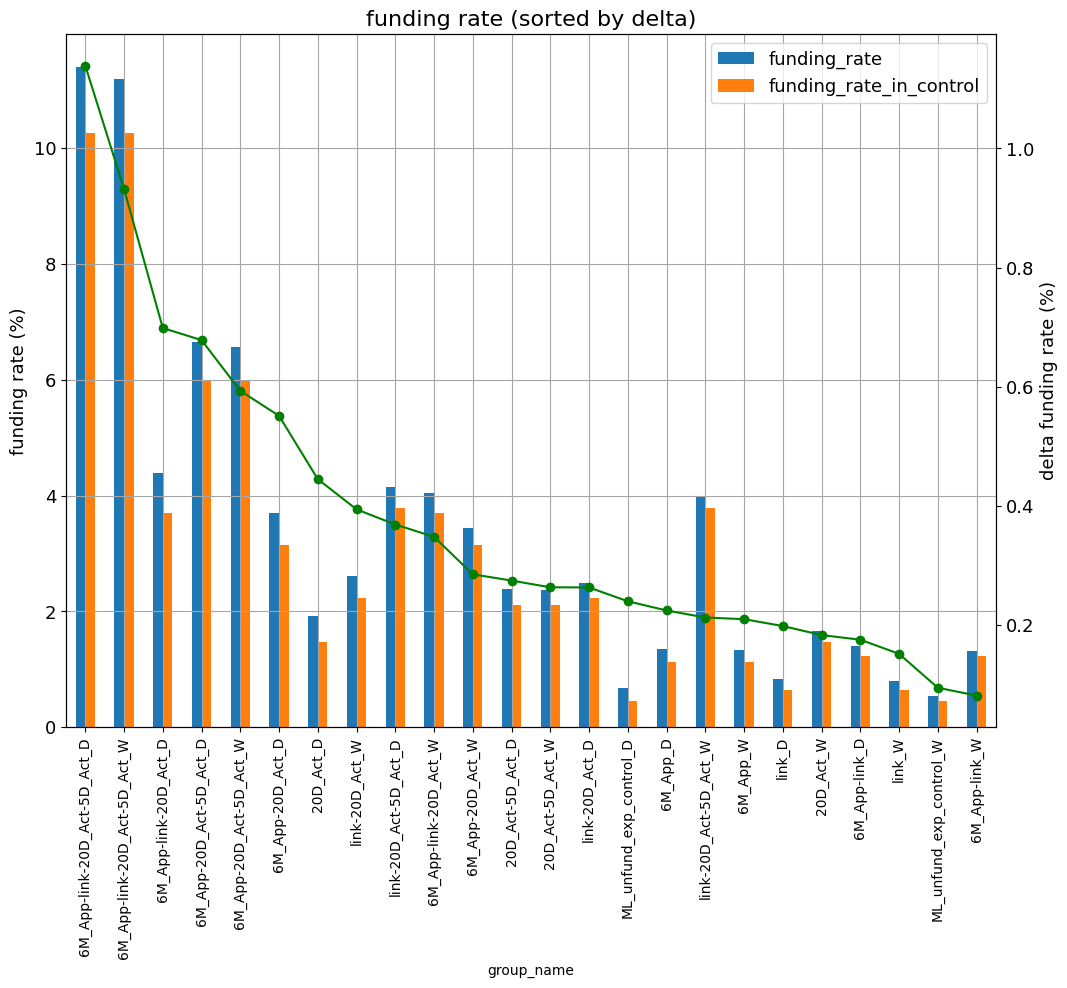

In [49]:
ax = temp.plot(x="group_name", y=["funding_rate", "funding_rate_in_control"], kind="bar",figsize=(12, 9))

plt.xticks(fontsize=10)
plt.yticks(fontsize=13)
plt.ylabel('funding rate (%)',fontsize=13)
plt.title('funding rate (sorted by delta)',fontsize=16)

plt.legend(fontsize=13)
plt.grid(which='both', color='0.65', linestyle='-')

ax2=ax.twinx()
ax2.plot(temp['group_name'], temp['delta_fund_rate'],color="green",marker="o")

ax2.set_ylabel('size')
plt.yticks(fontsize=13)
plt.ylabel('delta funding rate (%)',fontsize=13)

plt.show()

We can see barplot above to compare funding rate in treatment group and control group: treatment group is consistently greater than control group for all segments

Link rate barplot:

In [50]:
temp =exp_funding_merge_df[exp_funding_merge_df['link_rate']<1].sort_values('delta_link_rate',ascending=False)
temp[["link_rate", "link_rate_in_control",'delta_link_rate']] = temp[["link_rate", "link_rate_in_control",'delta_link_rate']]*100

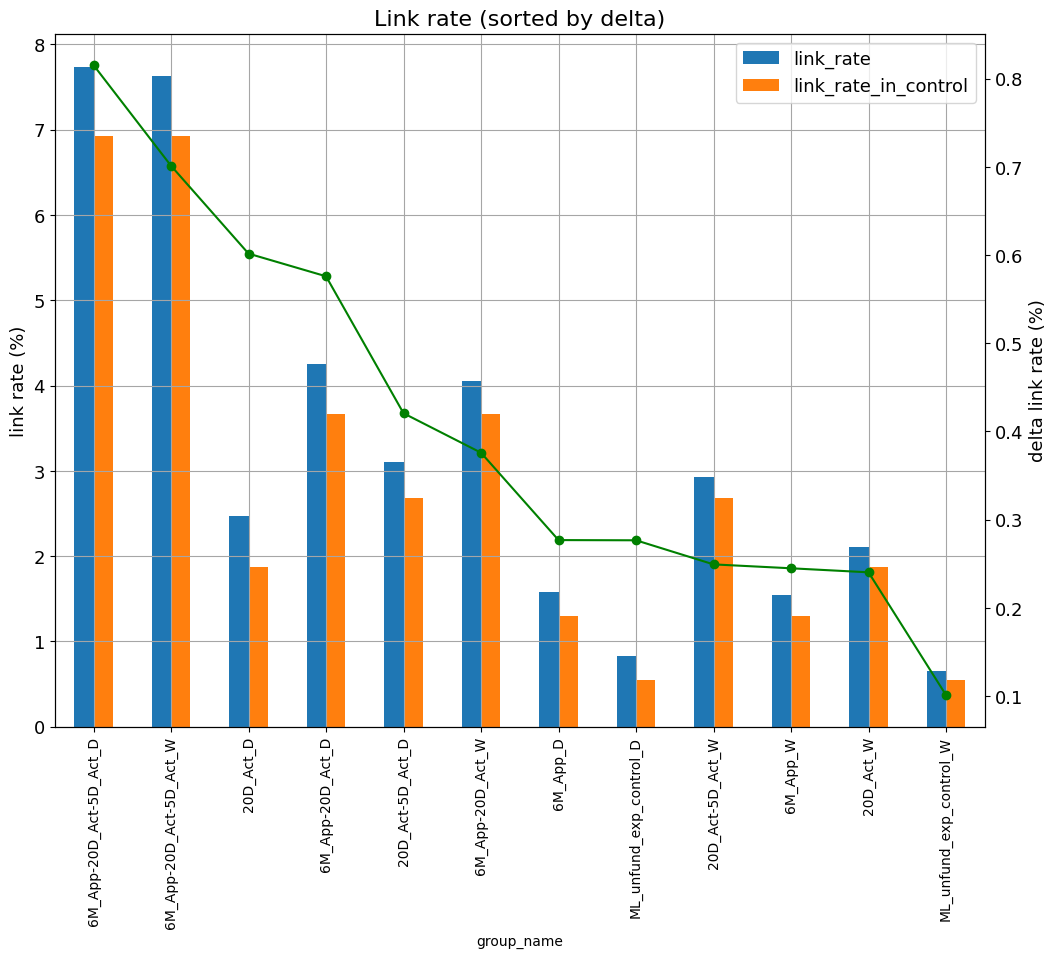

In [53]:
ax = temp.plot(x="group_name", y=["link_rate", "link_rate_in_control"], kind="bar",figsize=(12, 9))

plt.xticks(fontsize=10)
plt.yticks(fontsize=13)
plt.ylabel('link rate (%)',fontsize=13)
plt.title('Link rate (sorted by delta)',fontsize=16)

plt.legend(fontsize=13)
plt.grid(which='both', color='0.65', linestyle='-')

ax2=ax.twinx()
ax2.plot(temp['group_name'], temp['delta_link_rate'],color="green",marker="o")

#ax = temp['delta_fund_rate'].plot(secondary_y=True, color='k', marker='o',figsize=(16, 12))
ax2.set_ylabel('size')
plt.yticks(fontsize=13)
plt.ylabel('delta link rate (%)',fontsize=13)

plt.show()

For link rate, treatment groups are always greater than control groups.

# Time series analysis

Does Day_0 always have the highest Email open rate? If not, do you have some suggestions on the strategy to send Emails?

> We need to combine user message table and message order table together and make another table with indicator variables for open as entries for each day as column for each user as row:

In [54]:
user_event_df.head()

user_uuid               group_name  \
0   id_2623238174270264636  ML_unfund_exp_control_D   
1  id_14752263936159847779  ML_unfund_exp_control_D   
2   id_3723259155072282145  ML_unfund_exp_control_D   
3   id_9433964625840258739  ML_unfund_exp_control_D   
4  id_17251718038176858460  ML_unfund_exp_control_D   

  ml_funding_enables_investing ml_investing_starts_here  \
0                          NaN                      NaN   
1                    delivered                delivered   
2                    delivered                delivered   
3                    delivered                delivered   
4                          NaN                      NaN   

  ml_explore_the_app_investing ml_funding_faq ml_user_clustering_emails_fracs  \
0                          NaN            NaN                             NaN   
1                    delivered      delivered                       delivered   
2                         open           open                            open   
3                    delivered      delivered                       delivered   
4                          NaN            NaN                             NaN   

  ml_funding_is_safe ml_picking_an_investment ml_investing_101  \
0                NaN                      NaN              NaN   
1          delivered                delivered        delivered   
2          delivered                delivered        delivered   
3          delivered                delivered        delivered   
4                NaN                      NaN              NaN   

  ml_diversified_portfolio ml_explore_the_app_list              approved_at  \
0                      NaN                     NaN  2020-01-14 16:31:59.295   
1                     open               delivered  2019-01-29 16:22:26.866   
2                delivered                    open  2019-02-01 00:01:48.853   
3                delivered               delivered  2020-03-17 21:02:43.906   
4                      NaN                     NaN  2019-12-30 18:23:15.726   

           first_funded_at first_linked_bank_account_at  \
0                      NaN                          NaN   
1                      NaN                          NaN   
2  2020-12-04 20:41:55.146      2020-12-04 20:41:37.842   
3                      NaN                          NaN   
4                      NaN                          NaN   

   5d_trading_avg_event_count  2d_non_trading_avg_event_count  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                        53.0                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

   20d_trading_avg_event_count  8d_non_trading_avg_event_count  \
0                          NaN                             NaN   
1                          NaN                             NaN   
2                        171.0                             NaN   
3                          NaN                             NaN   
4                          NaN                             NaN   

   1d_trading_avg_event_count  1d_non_trading_avg_event_count  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

   num_received_email  total open  not na  
0                   0         0.0       0  
1                   9         1.0      10  
2                   6         4.0      10  
3                  10         0.0      10  
4                   0         0.0       0

In [55]:
sample_exp_df.head()

user_uuid  group_id               group_name  order_0  \
0   id_2623238174270264636         0  ML_unfund_exp_control_D        5   
1  id_14752263936159847779         0  ML_unfund_exp_control_D        3   
2   id_3723259155072282145         0  ML_unfund_exp_control_D        8   
3   id_9433964625840258739         0  ML_unfund_exp_control_D        1   
4  id_17251718038176858460         0  ML_unfund_exp_control_D        6   

   order_1  order_2  order_3  order_4  order_5  order_6  order_7  order_8  \
0        7        3        4        8        9        0        1        6   
1        1        6        0        5        9        4        8        7   
2        7        3        6        1        4        2        9        0   
3        8        0        6        5        7        4        9        3   
4        1        8        0        7        3        5        2        9   

   order_9  
0        2  
1        2  
2        5  
3        2  
4        4

We analyze users separately based on email strategy. Users receiving daily emails form into a group, users receiving weekly (twice a week) emails form into another group.

In [59]:
joined_df = sample_exp_df.merge(right=user_event_df,on="user_uuid",how='inner')
joined_df.drop("group_name_y",axis=1,inplace=True)
joined_df=joined_df.iloc[:,:23]
joined_df.head()
group_D=joined_df[joined_df["group_name_x"].apply(lambda x:x.endswith("D"))]
group_D.shape #240000
group_W=joined_df[joined_df["group_name_x"].apply(lambda x:x.endswith("W"))]
group_W.shape #240002

(240002, 23)

**For daily users:**

In [60]:
index = group_D.columns.get_loc("ml_funding_enables_investing")#it is the first message, we want to know which column it is
day_df=sample_exp_df.iloc[:,3:]#exclude first three columns, only contain message
rate_day=[]
#for each order day: function will give open rate for day i
def open_day(col_day):
    return(group_D.apply(lambda x:1 if x[x[col_day]+index] == 'open' else (np.NaN if pd.isnull(x[x[col_day]+index]) else 0),axis=1).mean(skipna=True))
#loop over all columns days:
for i in day_df.columns:
    rate_day.append(open_day(i))

<ipython-input-60-5aa121a598f2>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return(group_D.apply(lambda x:1 if x[x[col_day]+index] == 'open' else (np.NaN if pd.isnull(x[x[col_day]+index]) else 0),axis=1).mean(skipna=True))


In [61]:
#open rate for 10 days, sorted in descending order
open_rate_day=pd.DataFrame(rate_day,index=day_df.columns,columns=["open rate"]).sort_values(by="open rate",ascending=False)
open_rate_day

open rate
order_1   0.195782
order_2   0.193785
order_4   0.188251
order_0   0.186774
order_9   0.186674
order_3   0.186082
order_5   0.184930
order_7   0.184320
order_8   0.182201
order_6   0.166273

We observed that for daily users:
- For daily users, we can see that Day_0 is not the highest, the highest day is day_1.
- I can also see that everyday is relatively same. There is not much difference between different days for daily users exept for day 6 maybe it is a weekend

**For weekly group:**

In [62]:
index = group_W.columns.get_loc("ml_funding_enables_investing")#it is the first message, we want to know which column it is
day_df=sample_exp_df.iloc[:,3:]
rate_day=[]
#for each order day: function will give open rate for day i
def open_day(col_day):
    return(group_W.apply(lambda x:1 if x[x[col_day]+index] == 'open' else (np.NaN if pd.isnull(x[x[col_day]+index]) else 0),axis=1).mean(skipna=True))
#loop over all columns days:
for i in day_df.columns:
    rate_day.append(open_day(i))
#open rate for 10 days, sorted in descending order
open_rate_day=pd.DataFrame(rate_day,index=day_df.columns,columns=["open rate"]).sort_values(by="open rate",ascending=False)
open_rate_day

<ipython-input-62-7ad0b078b515>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return(group_W.apply(lambda x:1 if x[x[col_day]+index] == 'open' else (np.NaN if pd.isnull(x[x[col_day]+index]) else 0),axis=1).mean(skipna=True))


open rate
order_1   0.197959
order_2   0.194606
order_3   0.190820
order_0   0.188436
order_4   0.183940
order_5   0.183025
order_6   0.181744
order_7   0.174004
order_8   0.160040
order_9   0.000000

We observed that:
- day_0 is **not** the highest open rate, **the highest open rate is at day_1**. The second highest day is day_2.
 - The reason maybe people will remember the company after they already seen the email already. If the company continue sending emails on the second day, actually more people will open it.
- First few days have higher open rate than later days.
 - This means we should only send emails for a short time period. 4 weeks is too long to give positive response from users. People may get annoyed so they don't open anymore.
- **Day_9 has the open rate 0. This implies the experiment is not finished yet.**

Between daily and weekly:
- For the first few days, weekly strategy is better than daily strategy. Users tend to open emails more if we send emails twice a week rather than daily. But this only last for a week or so, if we email for a long perid of time, say two weeks, users tend to give no response and ignore emails. Hence, we should use twice a week strategy but no more than 2 weeks.

**Based on our current data, do you think the experiment has completely finished?**

No, there are a few problems need to investigate:
1. Delivery rate is very low for day 9. Only 4 deliveries on day 9 for weekly group users. On other days, delivery rate is roughly 77%. This is may be a system bug. It may affect A/B test because fund rate drops may be coming from the reason of low delivery rate not because of people's low interest in emails. Therefore, the A/B test result is underestimated.Day 9 data should not be included.

In [63]:
#type(group_W["ml_funding_enables_investing"].iloc[0])
group_W.apply(lambda x:1 if x[x["order_9"]+index]=="delivered" else 0,axis=1).mean()

<ipython-input-63-91d465971e5e>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_W.apply(lambda x:1 if x[x["order_9"]+index]=="delivered" else 0,axis=1).mean()


1.6666527778935175e-05

In [64]:
group_W.apply(lambda x:1 if x[x["order_0"]+index]=="delivered" else 0,axis=1).mean()

<ipython-input-64-50a517714fdc>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_W.apply(lambda x:1 if x[x["order_0"]+index]=="delivered" else 0,axis=1).mean()


0.7705227456437863

2. There are a lot of NaN values in message status data. For first 2 days, it is around 5%. For remaining days, it reaches 10%. It means not all people received emails even though our experiment design assume seach every email company sent will be received by users. It makes A/B test inconsistent becasue somedays more people received emails and other days fewer people received emails. The effect of funding rate may caused by the inconsistency. We need to investigate why NaN occurs so frequently.

In [65]:
group_W.apply(lambda x:1 if pd.isnull(x[x["order_8"]+index]) else 0,axis=1).mean()

<ipython-input-65-05494d52a718>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_W.apply(lambda x:1 if pd.isnull(x[x["order_8"]+index]) else 0,axis=1).mean()


0.10137832184731795

3. Message status contains "spamreport" and "unsubscribe". This is counter metric that we want to avoid. Even though some segment groups has postive result for A/B test, it may also brings about some issues: more users get annoyed so they report emails and even unsubscribe, so system more likely to predict emails as spams in the future. If we use the email strategy, in the long run maybe not all users will received emails because they are spams. It may not be effective as we expect in the future. Some users don't like our strategy so our company loss some money in the long run because lost users. So we should not only consider effectiveness of A/B test, but we need to calculate **unsubscribe rate or spamreport rate**, and weigh the pros and cons to see if we should send emails.

In [66]:
#type(group_W["ml_funding_enables_investing"].iloc[0])
group_W.apply(lambda x:x[x["order_6"]+index],axis=1).unique()

<ipython-input-66-95170c5b4a9b>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_W.apply(lambda x:x[x["order_6"]+index],axis=1).unique()


array([nan, 'open', 'delivered', 'spamreport', 'unsubscribe'],
      dtype=object)

4. I noticed for weekly users, the A/B test covers holidays: christmas and new year. These two days, users are less likely to read emails and even click on the links. So A/B test result may be underestimated.

# **Heatmap for each segment group with two frequencies versus each day:**





In [69]:
email_date_df = user_event_df[['user_uuid','group_name']+PO_number_list]
email_date_df.head()

user_uuid               group_name  \
0   id_2623238174270264636  ML_unfund_exp_control_D   
1  id_14752263936159847779  ML_unfund_exp_control_D   
2   id_3723259155072282145  ML_unfund_exp_control_D   
3   id_9433964625840258739  ML_unfund_exp_control_D   
4  id_17251718038176858460  ML_unfund_exp_control_D   

  ml_funding_enables_investing ml_investing_starts_here  \
0                          NaN                      NaN   
1                    delivered                delivered   
2                    delivered                delivered   
3                    delivered                delivered   
4                          NaN                      NaN   

  ml_explore_the_app_investing ml_funding_faq ml_user_clustering_emails_fracs  \
0                          NaN            NaN                             NaN   
1                    delivered      delivered                       delivered   
2                         open           open                            open   
3                    delivered      delivered                       delivered   
4                          NaN            NaN                             NaN   

  ml_funding_is_safe ml_picking_an_investment ml_investing_101  \
0                NaN                      NaN              NaN   
1          delivered                delivered        delivered   
2          delivered                delivered        delivered   
3          delivered                delivered        delivered   
4                NaN                      NaN              NaN   

  ml_diversified_portfolio ml_explore_the_app_list  
0                      NaN                     NaN  
1                     open               delivered  
2                delivered                    open  
3                delivered               delivered  
4                      NaN                     NaN

In [76]:
PO_number_dict = {}
for d in range(len(PO_number_list)):
    PO_number_dict[d] = PO_number_list[d]
email_event_name_df = sample_exp_df.copy()
for d in range(len(PO_number_list)):
    email_event_name_df['order_'+str(d)] = email_event_name_df['order_'+str(d)].map(PO_number_dict)

email_event_name_df.head()

user_uuid  group_id               group_name  \
0   id_2623238174270264636         0  ML_unfund_exp_control_D   
1  id_14752263936159847779         0  ML_unfund_exp_control_D   
2   id_3723259155072282145         0  ML_unfund_exp_control_D   
3   id_9433964625840258739         0  ML_unfund_exp_control_D   
4  id_17251718038176858460         0  ML_unfund_exp_control_D   

                    order_0                   order_1  \
0        ml_funding_is_safe          ml_investing_101   
1            ml_funding_faq  ml_investing_starts_here   
2  ml_diversified_portfolio          ml_investing_101   
3  ml_investing_starts_here  ml_diversified_portfolio   
4  ml_picking_an_investment  ml_investing_starts_here   

                        order_2                          order_3  \
0                ml_funding_faq  ml_user_clustering_emails_fracs   
1      ml_picking_an_investment     ml_funding_enables_investing   
2                ml_funding_faq         ml_picking_an_investment   
3  ml_funding_enables_investing         ml_picking_an_investment   
4      ml_diversified_portfolio     ml_funding_enables_investing   

                    order_4                          order_5  \
0  ml_diversified_portfolio          ml_explore_the_app_list   
1        ml_funding_is_safe          ml_explore_the_app_list   
2  ml_investing_starts_here  ml_user_clustering_emails_fracs   
3        ml_funding_is_safe                 ml_investing_101   
4          ml_investing_101                   ml_funding_faq   

                           order_6                       order_7  \
0     ml_funding_enables_investing      ml_investing_starts_here   
1  ml_user_clustering_emails_fracs      ml_diversified_portfolio   
2     ml_explore_the_app_investing       ml_explore_the_app_list   
3  ml_user_clustering_emails_fracs       ml_explore_the_app_list   
4               ml_funding_is_safe  ml_explore_the_app_investing   

                        order_8                          order_9  
0      ml_picking_an_investment     ml_explore_the_app_investing  
1              ml_investing_101     ml_explore_the_app_investing  
2  ml_funding_enables_investing               ml_funding_is_safe  
3                ml_funding_faq     ml_explore_the_app_investing  
4       ml_explore_the_app_list  ml_user_clustering_emails_fracs

In [84]:
merged_df = pd.merge(email_event_name_df, email_date_df, on=['user_uuid', 'group_name'])
result_df = pd.DataFrame()
result_df['user_uuid'] = merged_df['user_uuid']
result_df['group_name'] = merged_df['group_name']


In [86]:
merged_df.head()

user_uuid  group_id               group_name  \
0   id_2623238174270264636         0  ML_unfund_exp_control_D   
1  id_14752263936159847779         0  ML_unfund_exp_control_D   
2   id_3723259155072282145         0  ML_unfund_exp_control_D   
3   id_9433964625840258739         0  ML_unfund_exp_control_D   
4  id_17251718038176858460         0  ML_unfund_exp_control_D   

                    order_0                   order_1  \
0        ml_funding_is_safe          ml_investing_101   
1            ml_funding_faq  ml_investing_starts_here   
2  ml_diversified_portfolio          ml_investing_101   
3  ml_investing_starts_here  ml_diversified_portfolio   
4  ml_picking_an_investment  ml_investing_starts_here   

                        order_2                          order_3  \
0                ml_funding_faq  ml_user_clustering_emails_fracs   
1      ml_picking_an_investment     ml_funding_enables_investing   
2                ml_funding_faq         ml_picking_an_investment   
3  ml_funding_enables_investing         ml_picking_an_investment   
4      ml_diversified_portfolio     ml_funding_enables_investing   

                    order_4                          order_5  \
0  ml_diversified_portfolio          ml_explore_the_app_list   
1        ml_funding_is_safe          ml_explore_the_app_list   
2  ml_investing_starts_here  ml_user_clustering_emails_fracs   
3        ml_funding_is_safe                 ml_investing_101   
4          ml_investing_101                   ml_funding_faq   

                           order_6                       order_7  \
0     ml_funding_enables_investing      ml_investing_starts_here   
1  ml_user_clustering_emails_fracs      ml_diversified_portfolio   
2     ml_explore_the_app_investing       ml_explore_the_app_list   
3  ml_user_clustering_emails_fracs       ml_explore_the_app_list   
4               ml_funding_is_safe  ml_explore_the_app_investing   

                        order_8                          order_9  \
0      ml_picking_an_investment     ml_explore_the_app_investing   
1              ml_investing_101     ml_explore_the_app_investing   
2  ml_funding_enables_investing               ml_funding_is_safe   
3                ml_funding_faq     ml_explore_the_app_investing   
4       ml_explore_the_app_list  ml_user_clustering_emails_fracs   

  ml_funding_enables_investing ml_investing_starts_here  \
0                          NaN                      NaN   
1                    delivered                delivered   
2                    delivered                delivered   
3                    delivered                delivered   
4                          NaN                      NaN   

  ml_explore_the_app_investing ml_funding_faq ml_user_clustering_emails_fracs  \
0                          NaN            NaN                             NaN   
1                    delivered      delivered                       delivered   
2                         open           open                            open   
3                    delivered      delivered                       delivered   
4                          NaN            NaN                             NaN   

  ml_funding_is_safe ml_picking_an_investment ml_investing_101  \
0                NaN                      NaN              NaN   
1          delivered                delivered        delivered   
2          delivered                delivered        delivered   
3          delivered                delivered        delivered   
4                NaN                      NaN              NaN   

  ml_diversified_portfolio ml_explore_the_app_list  
0                      NaN                     NaN  
1                     open               delivered  
2                delivered                    open  
3                delivered               delivered  
4                      NaN                     NaN

In [87]:
for day in range(10):  # Assuming days 0 to 9
    day_column = f'order_{day}'
    result_df[day_column] = merged_df.apply(
        lambda row: row[row[day_column]],
        axis=1
    )
result_df

user_uuid                    group_name    order_0  \
0        id_2623238174270264636       ML_unfund_exp_control_D        NaN   
1       id_14752263936159847779       ML_unfund_exp_control_D  delivered   
2        id_3723259155072282145       ML_unfund_exp_control_D  delivered   
3        id_9433964625840258739       ML_unfund_exp_control_D  delivered   
4       id_17251718038176858460       ML_unfund_exp_control_D        NaN   
...                         ...                           ...        ...   
479997   id_5040937410148515023  6M_App-link-20D_Act-5D_Act_W  delivered   
479998    id_786871754221668715  6M_App-link-20D_Act-5D_Act_W  delivered   
479999   id_5562306837451033542  6M_App-link-20D_Act-5D_Act_W  delivered   
480000   id_7974070474102470703  6M_App-link-20D_Act-5D_Act_W  delivered   
480001  id_12975769446544655561  6M_App-link-20D_Act-5D_Act_W       open   

          order_1    order_2    order_3    order_4    order_5    order_6  \
0             NaN        NaN        NaN        NaN        NaN        NaN   
1       delivered  delivered  delivered  delivered  delivered  delivered   
2       delivered       open  delivered  delivered       open       open   
3       delivered  delivered  delivered  delivered  delivered  delivered   
4             NaN        NaN        NaN        NaN        NaN        NaN   
...           ...        ...        ...        ...        ...        ...   
479997  delivered       open       open  delivered  delivered       open   
479998  delivered       open  delivered  delivered       open  delivered   
479999  delivered  delivered  delivered  delivered  delivered  delivered   
480000  delivered  delivered  delivered  delivered  delivered  delivered   
480001       open  delivered  delivered  delivered       open       open   

          order_7    order_8    order_9  
0             NaN        NaN        NaN  
1            open  delivered  delivered  
2            open  delivered  delivered  
3       delivered  delivered  delivered  
4             NaN        NaN        NaN  
...           ...        ...        ...  
479997  delivered  delivered        NaN  
479998  delivered       open        NaN  
479999  delivered  delivered        NaN  
480000  delivered  delivered        NaN  
480001       open       open        NaN  

[480002 rows x 12 columns]

In [88]:
email_event_TS_df=result_df

In [89]:
day_list = []
for i in range(len(PO_number_list)):
    day_list.append('order_' + str(i))

#delivered_count_df = user_event_df.drop(columns=['user_uuid'])
delivered_count_TS_df = email_event_TS_df[['user_uuid','group_name']+day_list]
for e in day_list:
    delivered_count_TS_df[e] = delivered_count_TS_df[e].notnull()

delivered_count_TS_df = delivered_count_TS_df.groupby('group_name').sum().reset_index()

In [90]:
delivered_count_TS_df.head()

group_name                                          user_uuid  \
0         20D_Act-5D_Act_D  id_108730096545553319id_17033316498541460763id...   
1         20D_Act-5D_Act_W  id_2056875396497046488id_1805272204200540957id...   
2                20D_Act_D  id_18066165271746208616id_6958192350271394294i...   
3                20D_Act_W  id_13471668544681414958id_1648044025520909996i...   
4  6M_App-20D_Act-5D_Act_D  id_16995527587209681272id_10930775585852851635...   

   order_0  order_1  order_2  order_3  order_4  order_5  order_6  order_7  \
0    19455    19410    19378    19337    19271    19197    19167    19138   
1    19441    19345    19319    19280    19259    19207    19181    19138   
2    19324    19265    19205    19149    19089    18959    18928    18901   
3    19301    19176    19088    19051    19018    18946    18921    18888   
4    19526    19462    19409    19364    19316    19202    19173    19156   

   order_8  order_9  
0    19099    19068  
1    19121        0  
2    18866    18835  
3    18863        0  
4    19125    19100

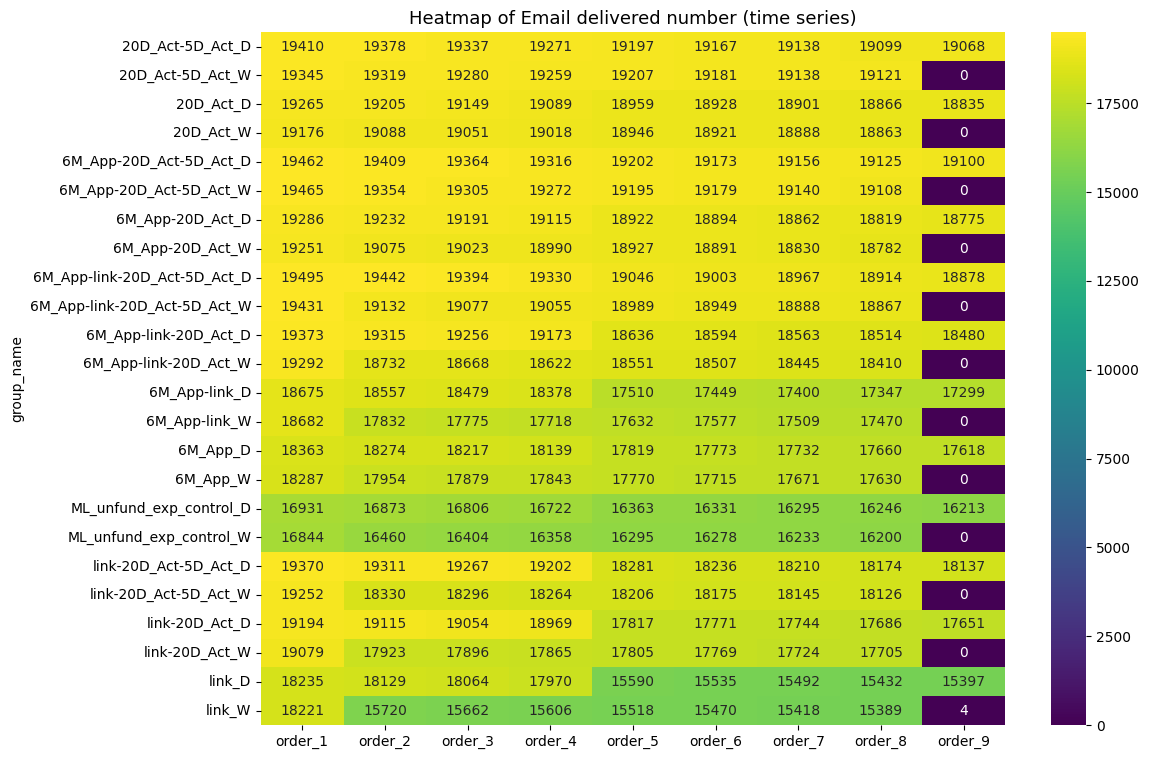

In [98]:
result = delivered_count_TS_df[delivered_count_TS_df['group_name'].str.contains('_D')].set_index('group_name')
result = delivered_count_TS_df.set_index('group_name')
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(result.iloc[:,2:], annot=True, fmt="g", cmap='viridis')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Heatmap of Email delivered number (time series)',fontsize=13)


plt.show()

In [94]:
#open_count_df = user_event_df.drop(columns=['user_uuid'])
open_count_TS_df = email_event_TS_df[['user_uuid','group_name']+day_list]
for e in day_list:
    open_count_TS_df[e] = open_count_TS_df[e] == 'open'

open_count_TS_df = open_count_TS_df.groupby('group_name').sum().reset_index()
open_count_TS_df.head()

group_name                                          user_uuid  \
0         20D_Act-5D_Act_D  id_108730096545553319id_17033316498541460763id...   
1         20D_Act-5D_Act_W  id_2056875396497046488id_1805272204200540957id...   
2                20D_Act_D  id_18066165271746208616id_6958192350271394294i...   
3                20D_Act_W  id_13471668544681414958id_1648044025520909996i...   
4  6M_App-20D_Act-5D_Act_D  id_16995527587209681272id_10930775585852851635...   

   order_0  order_1  order_2  order_3  order_4  order_5  order_6  order_7  \
0     3341     3694     3608     3425     3467     3364     2902     3405   
1     3417     3650     3565     3501     3459     3497     3378     3218   
2     3700     3825     3882     3787     3730     3678     3291     3612   
3     3637     3886     3826     3746     3601     3533     3597     3374   
4     3839     3956     3830     3678     3756     3658     3101     3591   

   order_8  order_9  
0     3311     3543  
1     2947        0  
2     3593     3632  
3     3229        0  
4     3578     3658

In [95]:
open_rate_TS_df = open_count_TS_df
for e in day_list:
    open_rate_TS_df[e] = open_count_TS_df[e]/delivered_count_TS_df[e]

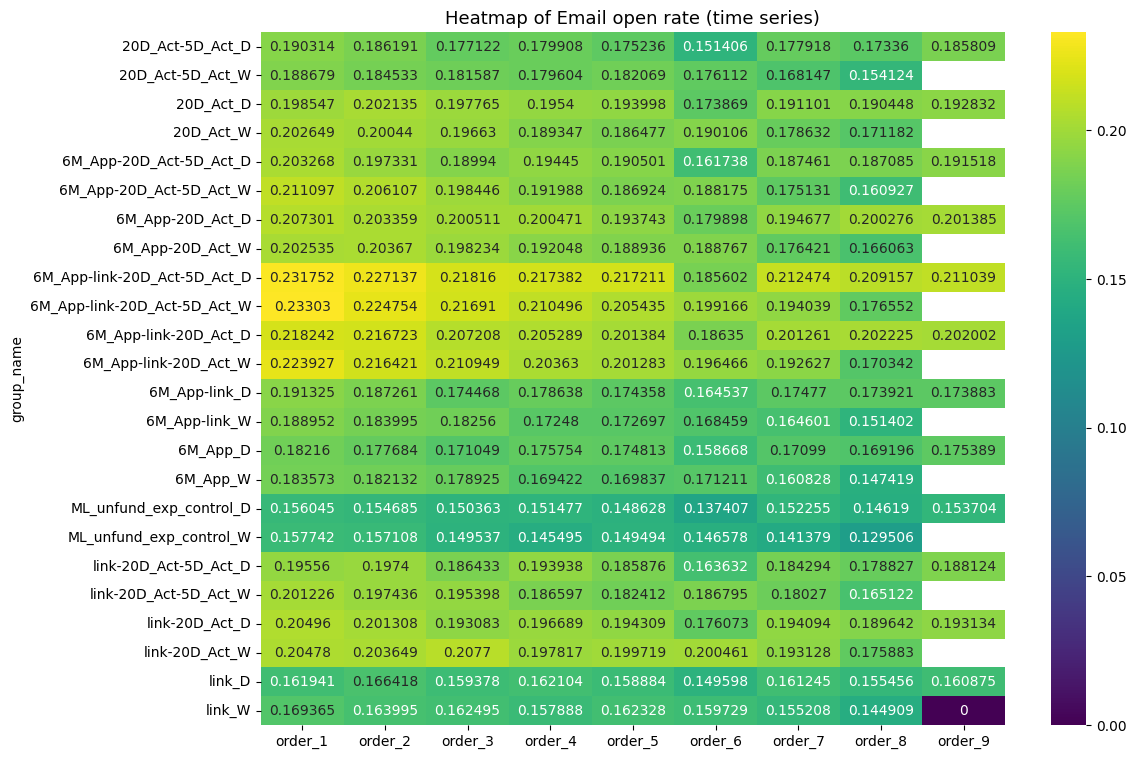

In [97]:
result = open_rate_TS_df[open_rate_TS_df['group_name'].str.contains('_D')].set_index('group_name')
# uncomment after the experiment finishes
result = open_rate_TS_df.set_index('group_name')
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(result.iloc[:,2:], annot=True, fmt="g", cmap='viridis')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Heatmap of Email open rate (time series)',fontsize=13)


plt.show()

# Funnel analysis


In [100]:
rate_funnel_df = exp_funding_merge_df[['group_name','link_rate','act_rate','funding_rate','link_rate_in_control',
                                       'funding_rate_in_control','delta_link_rate','delta_fund_rate']]
rate_funnel_df['max_Email_open_rate'] = open_rate_TS_df.iloc[:,2:].max(axis=1)#find maximum day open rate
rate_funnel_df['delta_rate_funnel'] = rate_funnel_df['max_Email_open_rate'] - rate_funnel_df['funding_rate']
rate_funnel_df['extra_conversion_rate'] = rate_funnel_df['delta_fund_rate'] / rate_funnel_df['max_Email_open_rate']
rate_funnel_df.head()

<ipython-input-100-c71e679ca94e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_funnel_df['max_Email_open_rate'] = open_rate_TS_df.iloc[:,2:].max(axis=1)#find maximum day open rate
<ipython-input-100-c71e679ca94e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_funnel_df['delta_rate_funnel'] = rate_funnel_df['max_Email_open_rate'] - rate_funnel_df['funding_rate']
<ipython-input-100-c71e679ca94e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

group_name  link_rate  act_rate  funding_rate  \
0         20D_Act-5D_Act_D   0.030976  1.000000      0.023840   
1         20D_Act-5D_Act_W   0.029263  1.000000      0.023727   
2                20D_Act_D   0.024723  0.558906      0.019187   
3                20D_Act_W   0.021111  0.558174      0.016568   
4  6M_App-20D_Act-5D_Act_D   0.077403  1.000000      0.066519   

   link_rate_in_control  funding_rate_in_control  delta_link_rate  \
0              0.026770                 0.021099         0.004206   
1              0.026770                 0.021099         0.002493   
2              0.018707                 0.014742         0.006016   
3              0.018707                 0.014742         0.002403   
4              0.069250                 0.059738         0.008153   

   delta_fund_rate  max_Email_open_rate  delta_rate_funnel  \
0         0.002741             0.190314           0.166475   
1         0.002628             0.188679           0.164953   
2         0.004445             0.202135           0.182948   
3         0.001825             0.202649           0.186081   
4         0.006781             0.203268           0.136749   

   extra_conversion_rate  
0               0.014403  
1               0.013928  
2               0.021990  
3               0.009008  
4               0.033359

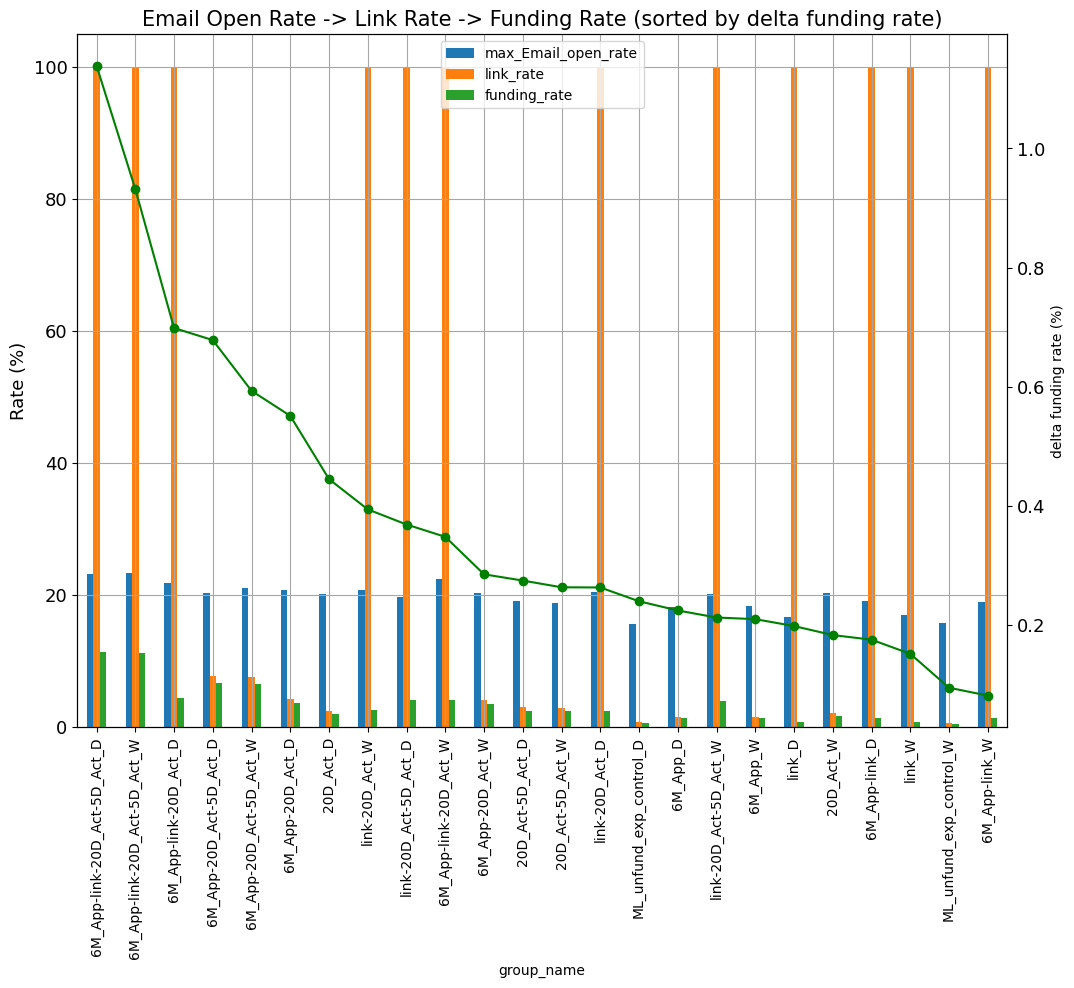

In [104]:
#temp =rate_funnel_df#[rate_funnel_df['link_rate']<1].sort_values('delta_link_rate',ascending=False)
temp =rate_funnel_df.sort_values('delta_fund_rate',ascending=False)

num_list = temp.select_dtypes(include=np.number).columns.tolist()
temp[num_list] = temp[num_list]*100

ax = temp.plot(x="group_name", y=["max_Email_open_rate", "link_rate", "funding_rate"], kind="bar",figsize=(12, 9))

plt.xticks(fontsize=10)
plt.yticks(fontsize=13)
plt.ylabel('Rate (%)',fontsize=13)
plt.title('Email Open Rate -> Link Rate -> Funding Rate (sorted by delta funding rate)',fontsize=15)

plt.legend(fontsize=10)
plt.grid(which='both', color='0.65', linestyle='-')

ax2=ax.twinx()
ax2.plot(temp['group_name'], temp['delta_fund_rate'],color="green",marker="o")

#ax = temp['delta_fund_rate'].plot(secondary_y=True, color='k', marker='o',figsize=(16, 12))
ax2.set_ylabel('size')
plt.yticks(fontsize=13)
plt.ylabel('delta funding rate (%)',fontsize=10)

plt.show()

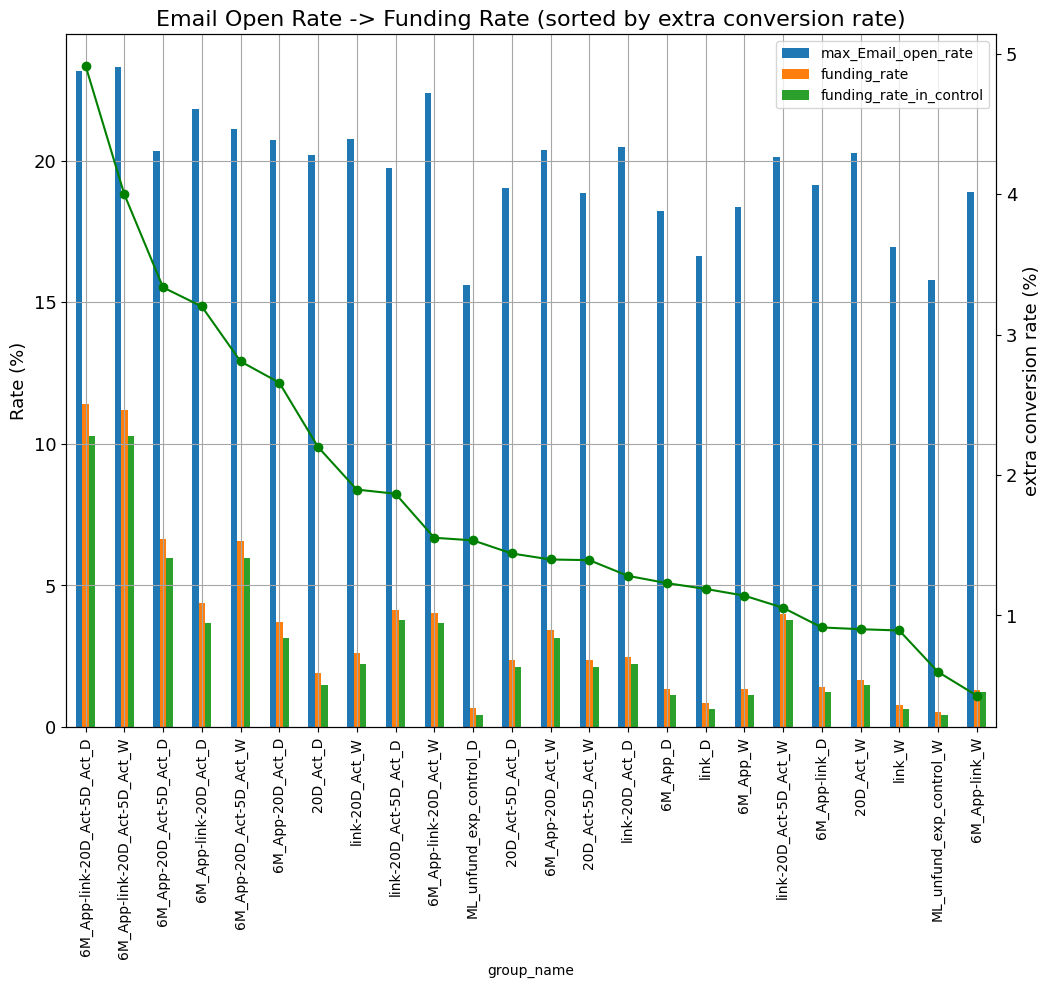

In [108]:
#temp =rate_funnel_df#[rate_funnel_df['link_rate']<1].sort_values('delta_link_rate',ascending=False)
temp =rate_funnel_df.sort_values('extra_conversion_rate',ascending=False)

num_list = temp.select_dtypes(include=np.number).columns.tolist()
temp[num_list] = temp[num_list]*100

ax = temp.plot(x="group_name", y=["max_Email_open_rate", "funding_rate","funding_rate_in_control"], kind="bar",figsize=(12, 9))

plt.xticks(fontsize=10)
plt.yticks(fontsize=13)
plt.ylabel('Rate (%)',fontsize=13)
plt.title('Email Open Rate -> Funding Rate (sorted by extra conversion rate)',fontsize=16)

plt.legend(fontsize=10)
plt.grid(which='both', color='0.65', linestyle='-')

ax2=ax.twinx()
ax2.plot(temp['group_name'], temp['extra_conversion_rate'],color="green",marker="o")

#ax = temp['delta_fund_rate'].plot(secondary_y=True, color='k', marker='o',figsize=(16, 12))
ax2.set_ylabel('size')
plt.yticks(fontsize=13)
plt.ylabel('extra conversion rate (%)',fontsize=13)

plt.show()

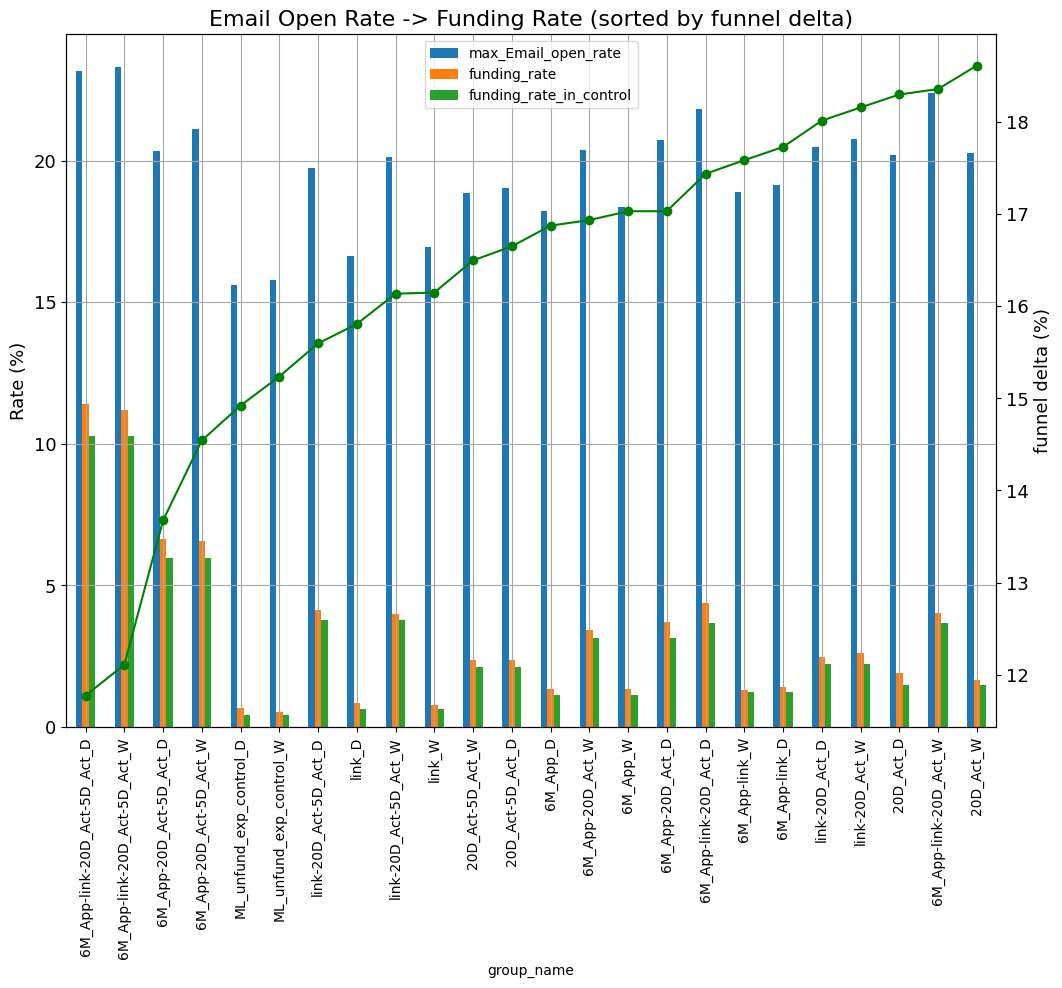

In [107]:
#temp =rate_funnel_df#[rate_funnel_df['link_rate']<1].sort_values('delta_link_rate',ascending=False)
temp =rate_funnel_df.sort_values('delta_rate_funnel')#,ascending=False)

num_list = temp.select_dtypes(include=np.number).columns.tolist()
temp[num_list] = temp[num_list]*100

ax = temp.plot(x="group_name", y=["max_Email_open_rate", "funding_rate","funding_rate_in_control"], kind="bar",figsize=(12, 9))

plt.xticks(fontsize=10)
plt.yticks(fontsize=13)
plt.ylabel('Rate (%)',fontsize=13)
plt.title('Email Open Rate -> Funding Rate (sorted by funnel delta)',fontsize=16)

plt.legend(fontsize=10)
plt.grid(which='both', color='0.65', linestyle='-')

ax2=ax.twinx()
ax2.plot(temp['group_name'], temp['delta_rate_funnel'],color="green",marker="o")

#ax = temp['delta_fund_rate'].plot(secondary_y=True, color='k', marker='o',figsize=(16, 12))
ax2.set_ylabel('size')
plt.yticks(fontsize=13)
plt.ylabel('funnel delta (%)',fontsize=13)

plt.show()